# The Dynamics of Energy Markets: Investigating the Relationship Between Crude Oil Prices, Market Volatility, and the S&P 500 Energy Index
## 
A Comprehensive Analysis of Long-Term Trends, Structural Shifts, and Sentiment Effects in the Energy Secor 

by Ghadena Hgaig



In [63]:
import os
import sys
import matplotlib.dates as mdates
from arch.unitroot import ZivotAndrews, PhillipsPerron
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
from stargazer.stargazer import Stargazer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from typing import List
import copy
from utils.utils import lspline

# Ignore warnings
warnings.filterwarnings("ignore")

## Introduction:

The goal of this analysis is to explore and quantify the relationships between crude oil prices, market volatility (VIX), and the S&P 500 Energy Sector Index. These relationships are critical for understanding the dynamics of the energy sector and for building robust predictive models that can guide investment and policy decisions


The analysis focuses on predictive insights, aiming to build models that forecast the energy index based on historical data. By leveraging multiple regression models with various transformations (e.g., log-log, first differences, and percentage returns), the analysis provides a comprehensive understanding of the underlying dynamics and interactions between variables. The central question that this paper aims to answer is the following
**: “What is the relationship between crude oil prices, market volatility (VIX), and the S&P 500 Energy Sector Index, and how do these factors interact to influence energy sector performance**?”


The dataset spans 30 years of monthly data, including crude oil prices, market volatility (VIX), the S&P 500 Energy Index, inflation rates (approximated by the Consumer Price Index, CPI), federal interest rates, the real broad effective exchange rate (REER), news sentiment analysis (post-2015 only),barrels of oil imported, and the S&P 500 Energy Index. The data was sourced from Yahoo Finance, the Federal Reserve Economic Data (FRED), EODHD, and Energy Information Administration (EIA) APIs. https://github.com/ghadena/winterproject 

In [67]:
# Define file paths using os.path.join for cross-platform compatibility
path_data = os.path.join('data', 'data.csv')
path_imports = os.path.join('data', 'imports.csv')
path_sentiment = os.path.join('data', 'sentiment.csv')

# Load the files into DataFrames
df = pd.read_csv(path_data)
df_i = pd.read_csv(path_imports)
df_s = pd.read_csv(path_sentiment)

# Data Cleaning and Preprocessing
df.drop(columns=['sector_sentiment', 'total_count', 'sentiment_category', 'Unnamed: 0'], inplace=True, errors='ignore')
df.rename(columns={"s&p_500_energy": "sp500_energy"}, inplace=True)
df_i.rename(columns={"Date": "date"}, inplace=True)

# Merge DataFrames
df = pd.merge(df, df_i, on='date', how='left')
df = pd.merge(df, df_s, on='date', how='left')

# Format and Sort Data
df['date'] = pd.to_datetime(df['date']).dt.normalize()
df = df.sort_values(by='date', ascending=False)
df.drop(columns=['weighted_sentiment'], inplace=True, errors='ignore')

# Summary of Data
print(df.head())
df.info()

          date  crude_oil_prices  interest_rates  reer_exchange  \
370 2024-11-01             69.95            4.64         112.54   
369 2024-10-01             71.99            4.83         110.00   
368 2024-09-01             70.24            5.13         108.77   
367 2024-08-01             76.68            5.33         109.32   
366 2024-07-01             81.80            5.33         110.39   

     consumption_expenditure      cpi        vix  sp500_energy  Unnamed: 0_x  \
370                  124.382  316.441  13.510000    724.059998           NaN   
369                  124.223  315.454  23.160000    681.250000           NaN   
368                  123.939  314.686  16.730000    676.469971         188.0   
367                  123.727  314.121  15.000000    695.859985         187.0   
366                  123.575  313.534  16.360001    712.419983         186.0   

      Quantity  Unnamed: 0_y  total_count sentiment_category  
370        NaN         112.0         19.0           N

## Explorator Data Analysis and Visualization

Distributions of variables
Crude oil prices show a positive trend over time, peaking during the 2008 financial crisis at $135 per barrel, then dropping to around $40 before stabilizing between $60 and $100 until 2014. Another sharp drop occurred during COVID-19. The energy index follows a similar distribution, mimicking oil price fluctuations. The VIX ranges from 10 to 60, with peaks during the dot-com bubble, the 2008 financial crisis, the Arab Spring, and COVID-19.

Control variables show the following distribution
s: Interest Rates: Fluctuate between 1% and 6% per month, peaking at similar times to the VI
X. REER: Exhibits an overall positive trend, with a downturn from 2000 to 2008, recovering to surpass its 2000 peak of 10
5. CPI: Displays a consistent positive linear tren
d. Barrels imported: Data available from 2009 onwards, a general declining trend in quantity from 2010 to 2024, with high volatility in the earlier years gradually stabilizing at lower levels after 201
6. News Sentiment: Predominantly positive, with peak counts during COVID-19, the Russia-Ukraine war, and the Israel-Palestine conflict. A downward trend is currently observed in energy company news covera
)



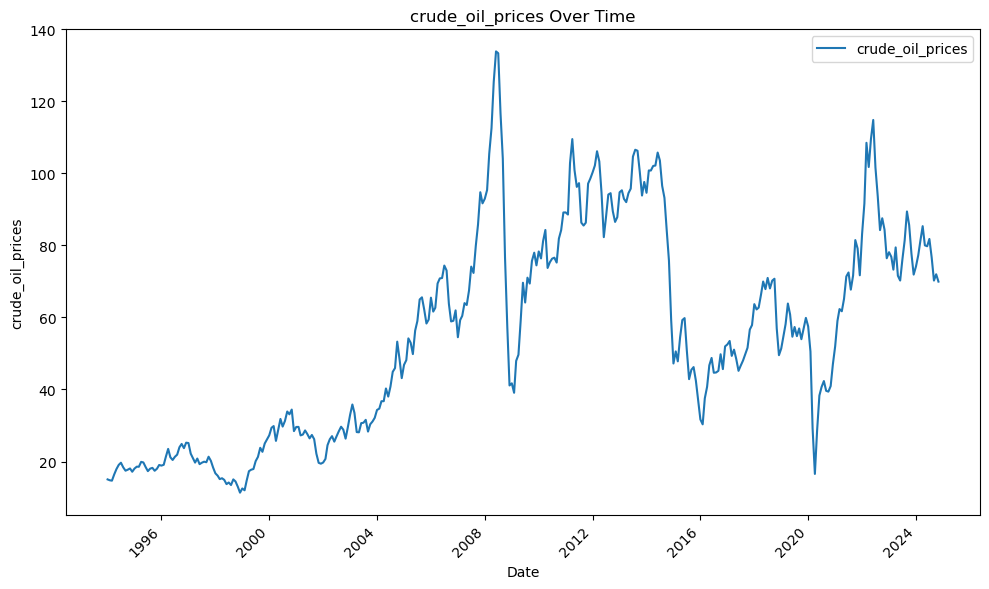

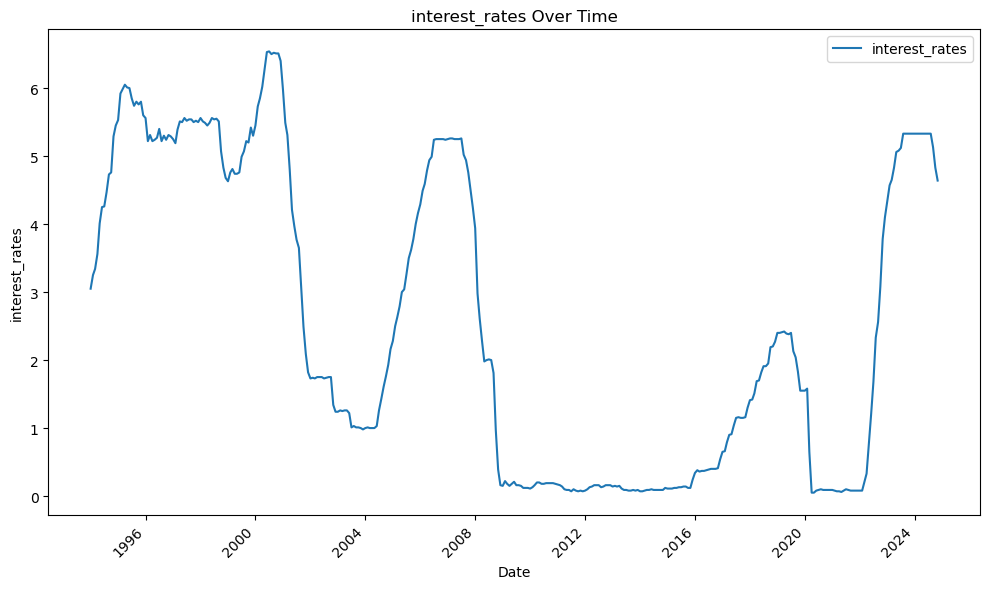

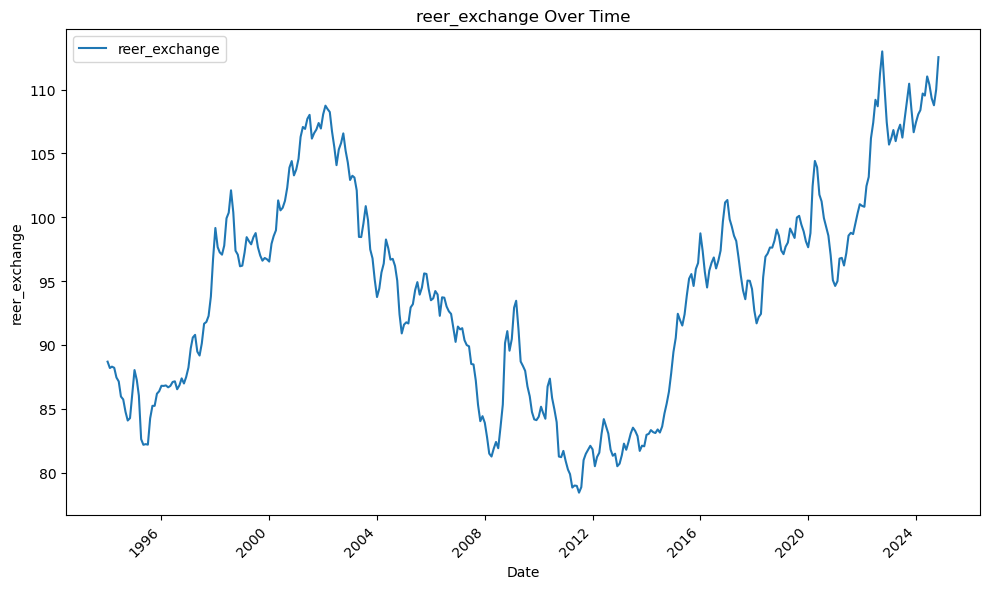

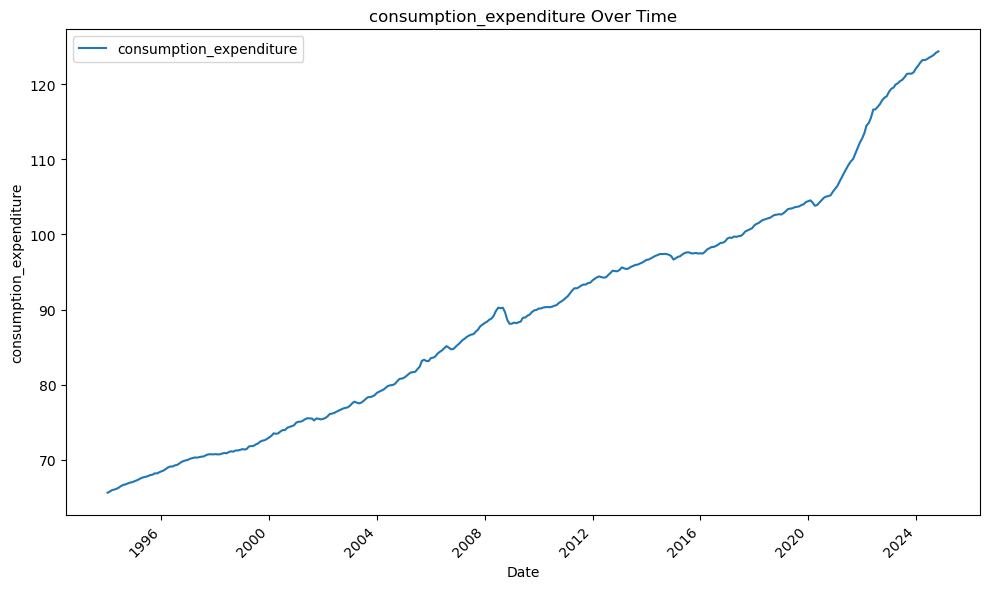

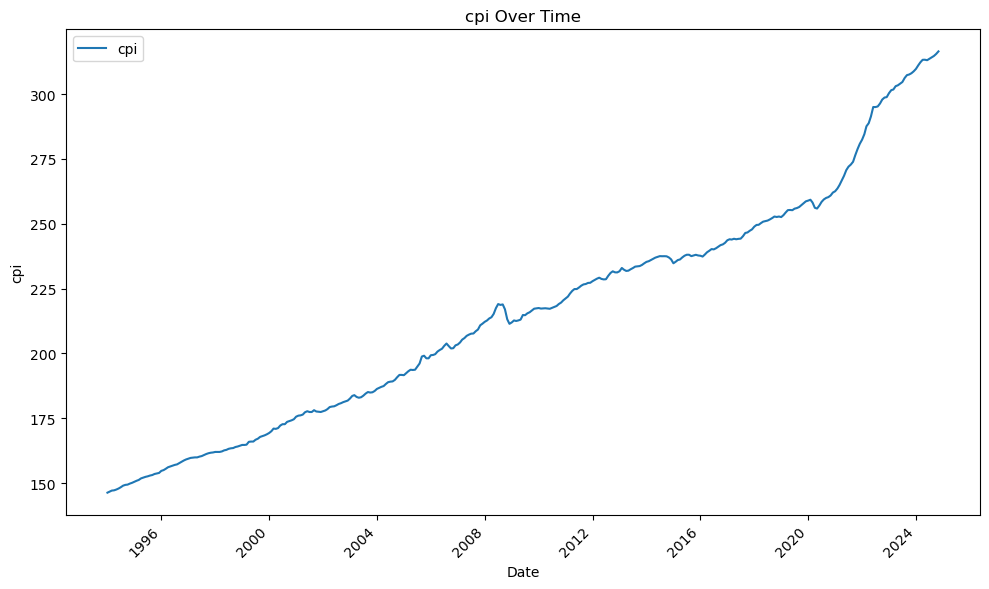

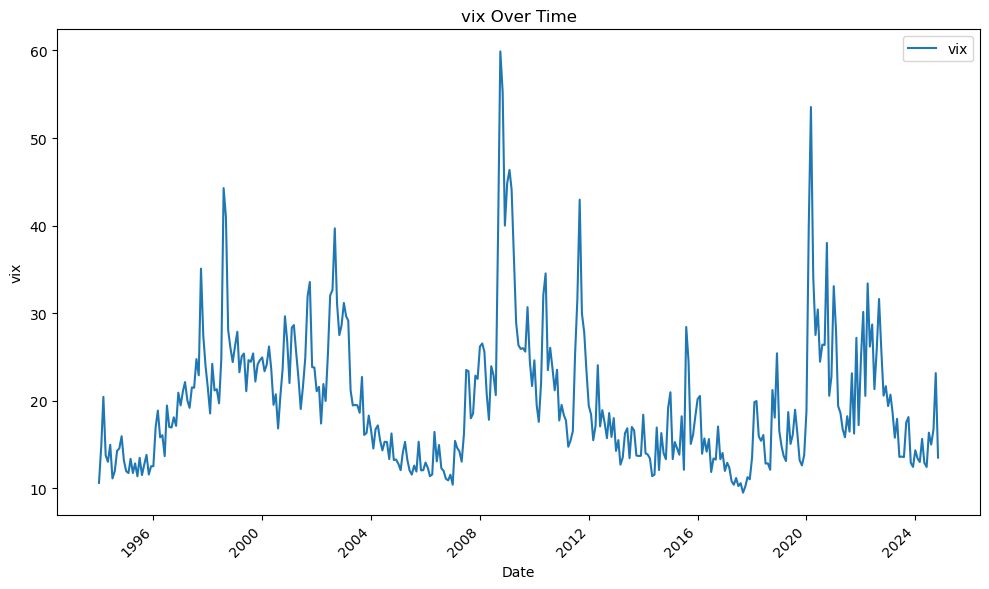

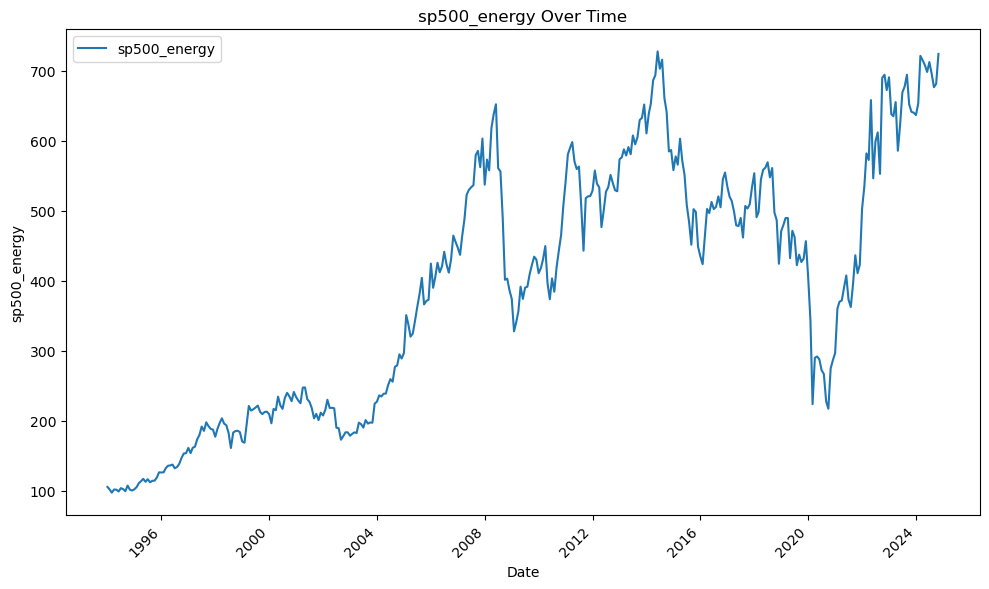

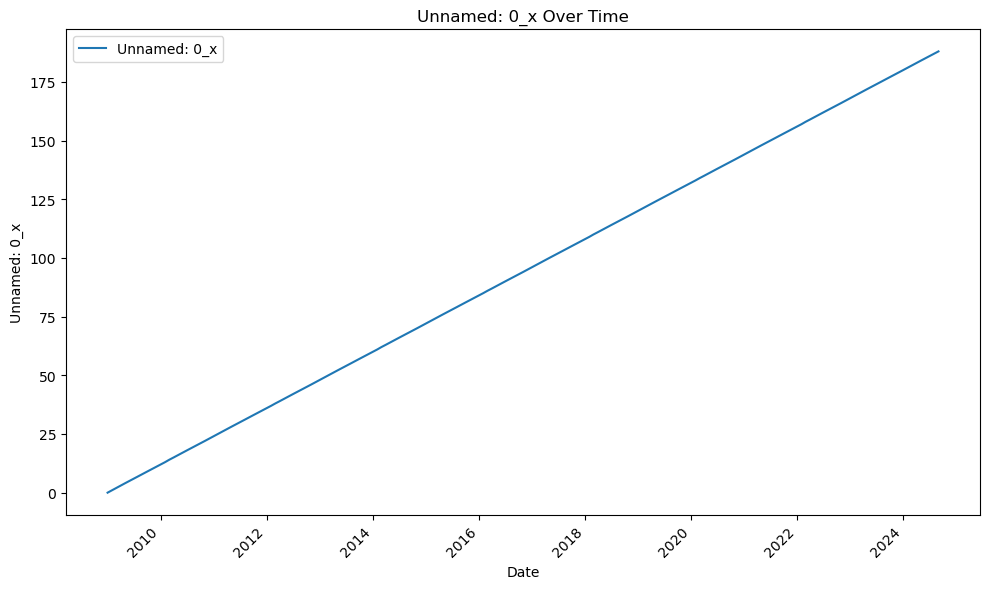

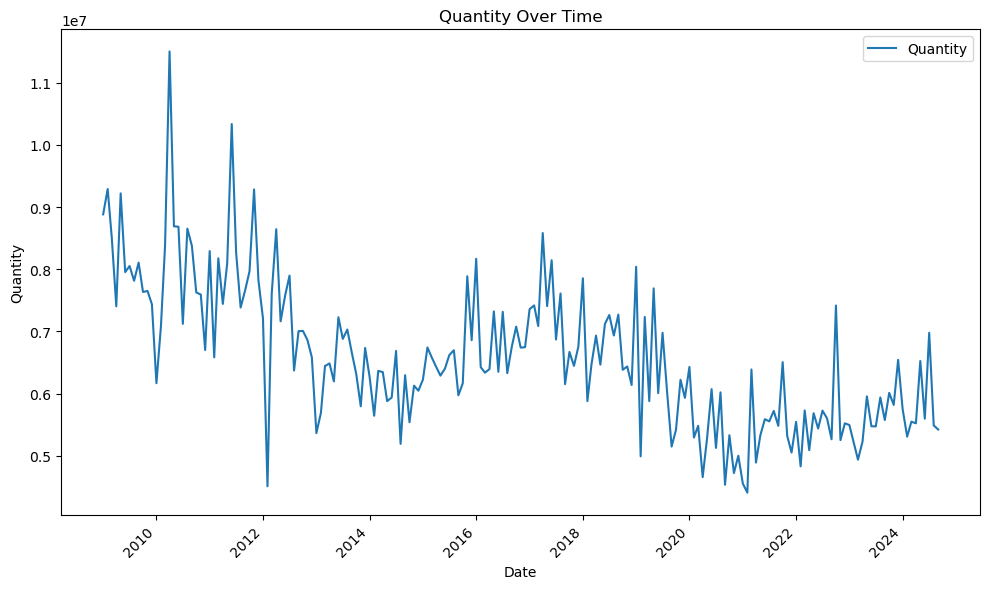

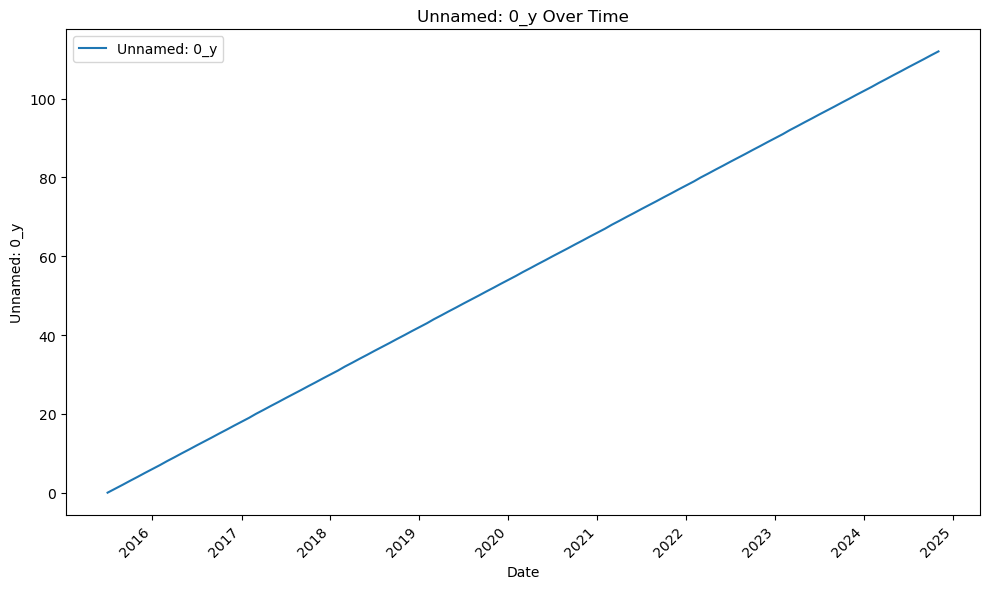

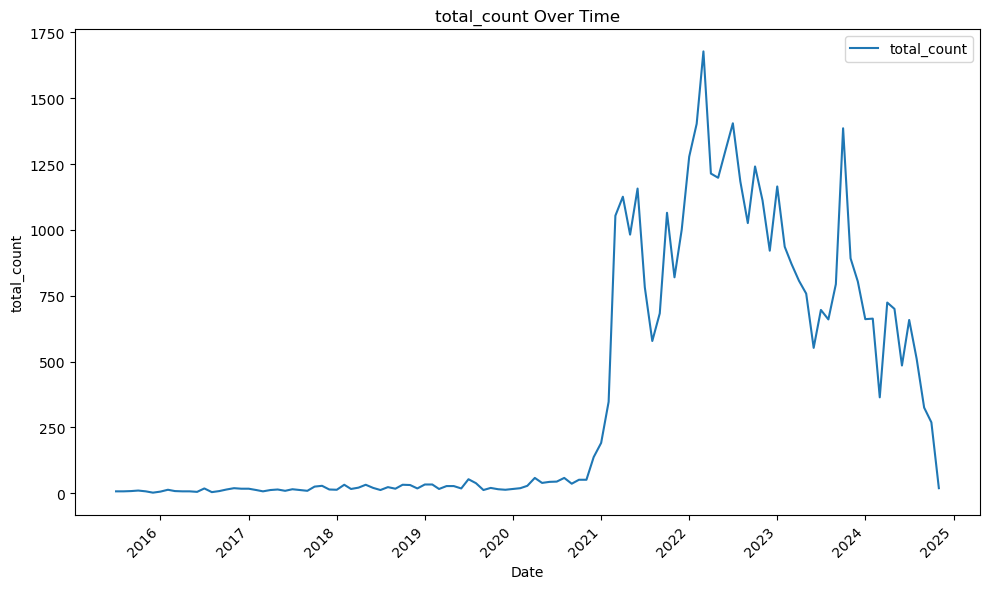

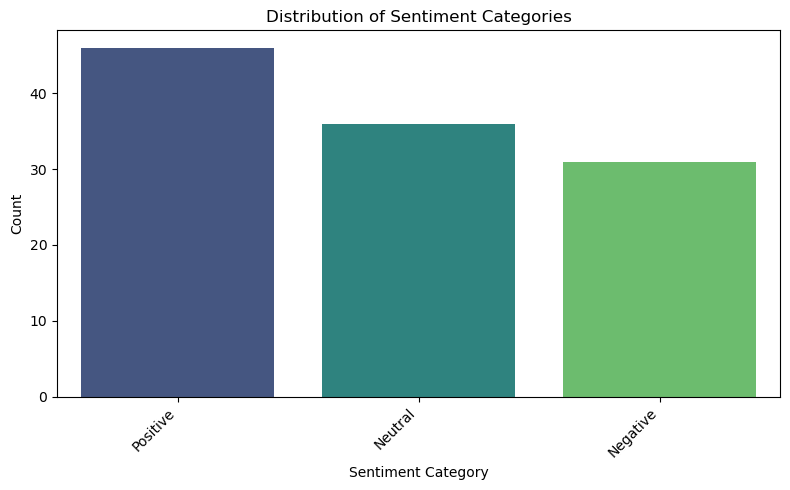

In [70]:
for var in df.columns:
    if var not in ['date', 'sentiment_category']:
        plt.figure(figsize=(10, 6))
        plt.plot(df['date'], df[var], linestyle='-', label=var)
        plt.title(f'{var} Over Time')
        plt.xlabel('Date')
        plt.ylabel(var)
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

# Sentiment Categories Distribution
if 'sentiment_category' in df.columns:
    sentiment_counts = df['sentiment_category'].value_counts()
    plt.figure(figsize=(8, 5))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette="viridis")
    plt.title('Distribution of Sentiment Categories')
    plt.xlabel('Sentiment Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [72]:
summary_stats = df[["sp500_energy", "crude_oil_prices", "vix", "interest_rates", "reer_exchange", "cpi", "Quantity"]].describe().T.round(2)
print(summary_stats)

                  count        mean         std         min         25%  \
sp500_energy      371.0      389.80      180.36       96.94      215.12   
crude_oil_prices  371.0       54.91       28.95       11.35       28.14   
vix               371.0       19.87        7.72        9.51       13.86   
interest_rates    371.0        2.55        2.25        0.05        0.16   
reer_exchange     371.0       94.10        8.49       78.43       86.77   
cpi               371.0      215.71       44.39      146.30      177.55   
Quantity          189.0  6588022.31  1167075.93  4406668.00  5684553.00   

                         50%         75%          max  
sp500_energy          411.38      539.26       727.63  
crude_oil_prices       53.47       76.65       133.88  
vix                    18.14       23.90        59.89  
interest_rates          1.82        5.12         6.54  
reer_exchange          94.92       99.46       112.99  
cpi                   217.00      243.95       316.44  
Quantit

## Feature Engineering 
Transformations applied: Log transformations, Calculating lags, First differences, Percentage and log returns. These transformations address the time-series nature of the data and allowed for exploration of different relationships.

## Imputing and handeling null values in 'News_sentiment' and 'Barrels_imported'
Observations post-January 1994 contains no null values, except for the news sentiment and imported barrel variables. I imputed the values with ‘NA’ and zeros and created a flag variable to identify the imputed observations. These imputations allowed us to utilize the full dataset, increasing the number of observations from 110 to approximately 370. This was essential for ensuring a more robust analysis



In [75]:
#log transformations 
df["ln_energy"] = np.log(df["sp500_energy"])
df["ln_oil"] = np.log(df["crude_oil_prices"])
df["ln_vix"] = np.log(df["vix"])
#lagged variables 
df["l_energy"] = df["sp500_energy"].shift()
df["l_oil"] = df["crude_oil_prices"].shift()
df["l_vix"] = df["vix"].shift()
#first difference 
df["d_energy"] = df["sp500_energy"] - df["l_energy"]
df["d_oil"] = df["crude_oil_prices"] - df["l_oil"]
df["d_vix"] = df["vix"] - df["l_vix"]
df["reer_exchange_diff"] = df["reer_exchange"].diff()
df["cpi_diff"] = df["cpi"].diff()
df["quantity_diff"] = df["Quantity"].diff()
#precentage return
df["PctRetEnergy"] = df["d_energy"] / df["l_energy"] * 100
df["PctRetOil"] = df["d_oil"] / df["l_oil"] * 100
df["PctRetVix"] = df["d_vix"] / df["l_vix"] * 100
#log return 
df["d_ln_energy"] = np.log(df["sp500_energy"]) - np.log(df["sp500_energy"].shift())
df["d_ln_oil"] = np.log(df["crude_oil_prices"]) - np.log(df["crude_oil_prices"].shift())
df["d_ln_vix"] = np.log(df["vix"]) - np.log(df["vix"].shift())
#squared VIX
df["sq_vix"] = (df["vix"])**2
#adding flag and imputed varibales for sentiment and quantity 
df['sentiment_category_full'] = df['sentiment_category'].fillna('NA')
df['sentiment_missig'] = (df['sentiment_category'].isna()).astype(int)
df['quantity_diff_full'] = df['quantity_diff'].fillna(0)
df['quantity_missing'] = (df['quantity_diff'].isna()).astype(int)
#map sentiment_category to a numerical sentiment scale
df['sentiment_num'] = df['sentiment_category'].map({
    'Positive': 1,
    'Neutral': 0,
    'Negative': -1})
#lagged differences 
df['reer_exchange_diff_lag1'] = df['reer_exchange_diff'].shift(1)
df['reer_exchange_diff_lag2'] = df['reer_exchange_diff'].shift(2)

## Visulizing the relationship between dependent and explanatory variables 


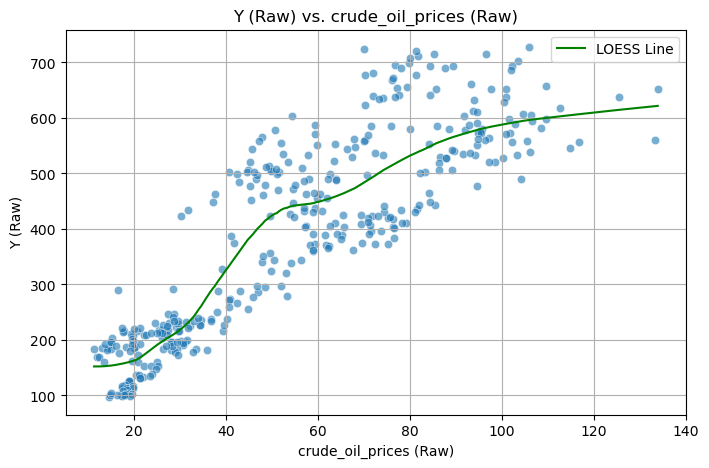

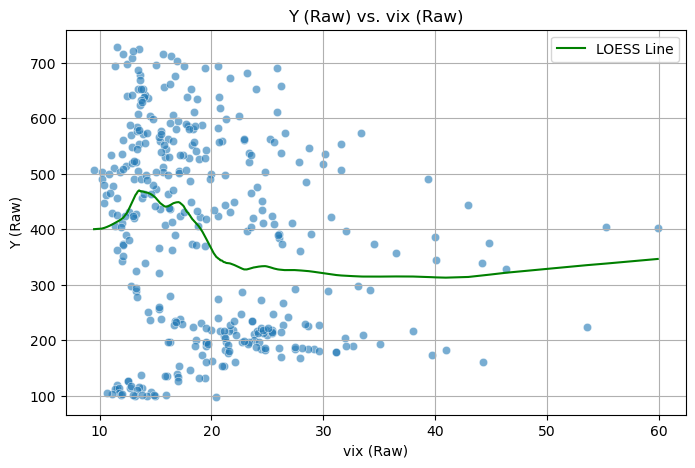

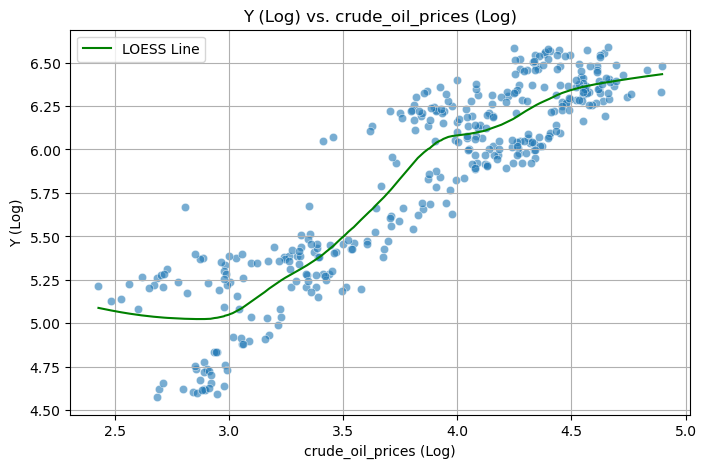

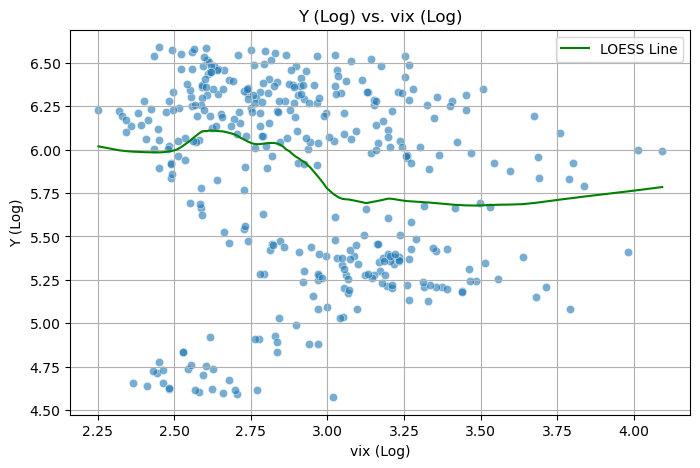

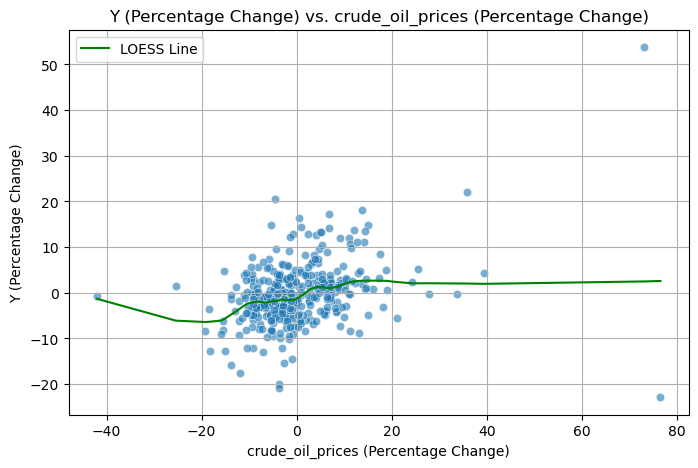

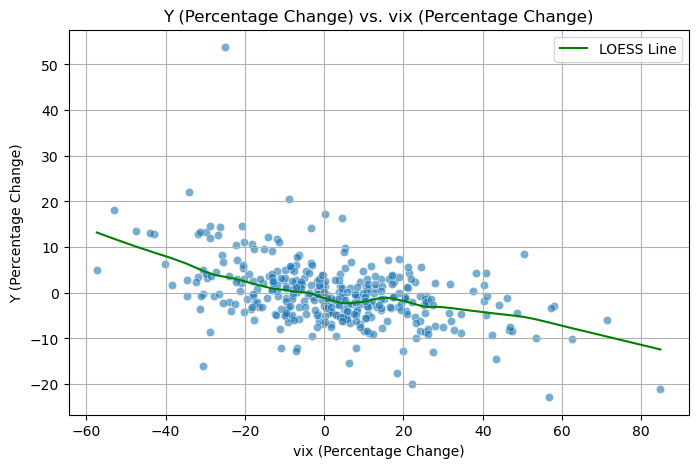

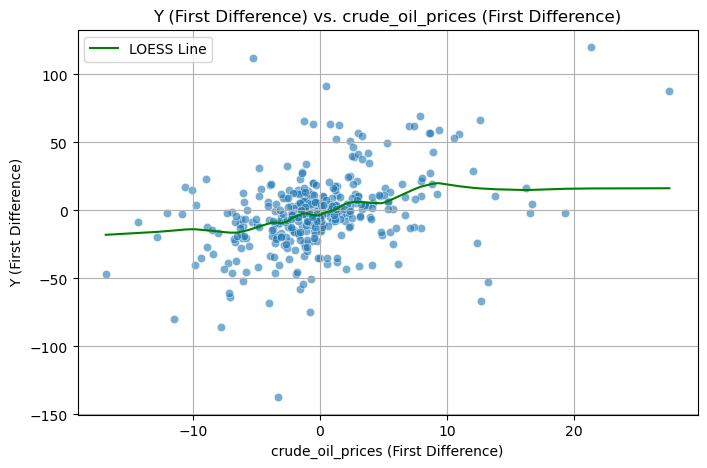

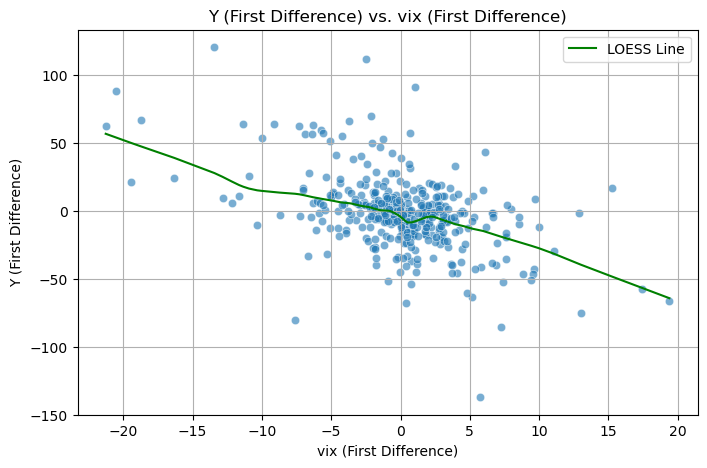

In [78]:
def explore_transformations(df, y_col, x_cols, transformations=["raw", "log", "pct_change", "diff"], line="loess"):
    """
    Explore the pattern of association between Y and each X variable with various transformations,
    adding a LOESS regression line or a no-width line.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        y_col (str): Column name for the dependent variable (Y).
        x_cols (list): List of column names for explanatory variables (X1, X2, etc.).
        transformations (list): List of transformations to apply ("raw", "log", "pct_change", "diff").
        line (str): Line to add to the plot. Options: "none", "no-width", "loess".
    
    Returns:
        None: Displays plots for each transformation.
    """
    for transform in transformations:
        # Apply the chosen transformation to Y and X variables
        if transform == "raw":
            y_trans = df[y_col]
            x_trans = {col: df[col] for col in x_cols}
            label = "Raw"
        elif transform == "log":
            y_trans = np.log(df[y_col])
            x_trans = {col: np.log(df[col]) for col in x_cols}
            label = "Log"
        elif transform == "pct_change":
            y_trans = df[y_col].pct_change() * 100
            x_trans = {col: df[col].pct_change() * 100 for col in x_cols}
            label = "Percentage Change"
        elif transform == "diff":
            y_trans = df[y_col].diff()
            x_trans = {col: df[col].diff() for col in x_cols}
            label = "First Difference"
        else:
            raise ValueError(f"Unknown transformation: {transform}")
        
        # Combine transformed variables into a DataFrame, dropping NaN rows
        combined_df = pd.DataFrame({f"Y ({label})": y_trans})
        for col in x_cols:
            combined_df[f"{col} ({label})"] = x_trans[col]
        combined_df = combined_df.dropna()

        # Plot the transformed X variables against the transformed Y
        for col in x_cols:
            plt.figure(figsize=(8, 5))
            sns.scatterplot(x=combined_df[f"{col} ({label})"], y=combined_df[f"Y ({label})"], alpha=0.6)
            
            if line == "no-width":
                # Add a diagonal reference line (identity line)
                plt.plot([combined_df[f"{col} ({label})"].min(), combined_df[f"{col} ({label})"].max()],
                         [combined_df[f"Y ({label})"].min(), combined_df[f"Y ({label})"].max()],
                         color="red", linestyle="--", label="No-Width Line")
            elif line == "loess":
                # Add a LOESS regression line
                loess_smoothed = lowess(
                    combined_df[f"Y ({label})"], combined_df[f"{col} ({label})"], frac=0.3
                )
                plt.plot(loess_smoothed[:, 0], loess_smoothed[:, 1], color="green", linestyle="-", label="LOESS Line")
            
            plt.title(f"Y ({label}) vs. {col} ({label})")
            plt.xlabel(f"{col} ({label})")
            plt.ylabel(f"Y ({label})")
            plt.grid(True)
            plt.legend()
            plt.show()

# Run the function with the desired settings
explore_transformations(
    df=df,
    y_col="sp500_energy", 
    x_cols=["crude_oil_prices", "vix"],
    transformations=["raw", "log", "pct_change", "diff"]
)

### exploring further transformations for VIX

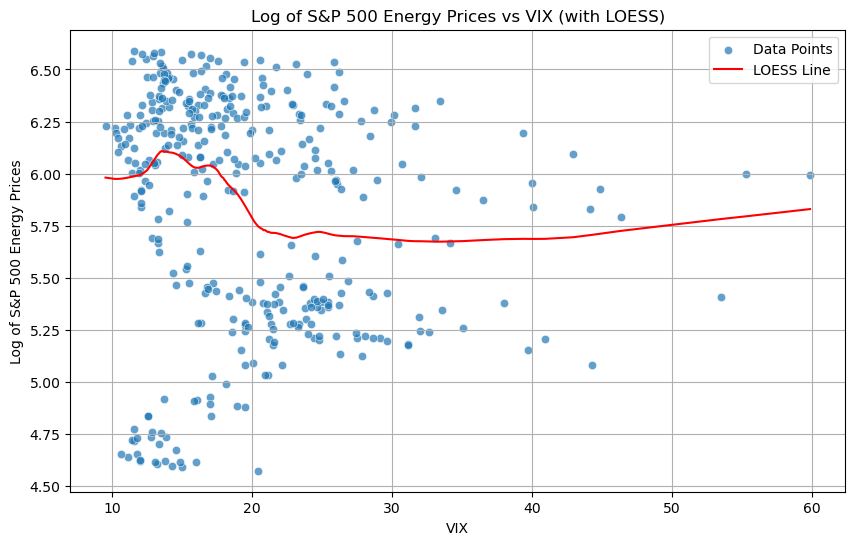

In [81]:
# Scatter plot with LOESS regression line
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['vix'], y=df['ln_energy'], alpha=0.7, label="Data Points")
# Add LOESS smoothing
lowess_smoothed = lowess(df['ln_energy'], df['vix'], frac=0.3)  # frac controls the smoothing span
plt.plot(lowess_smoothed[:, 0], lowess_smoothed[:, 1], color='red', label="LOESS Line")
# Plot aesthetics
plt.title("Log of S&P 500 Energy Prices vs VIX (with LOESS)")
plt.xlabel("VIX")
plt.ylabel("Log of S&P 500 Energy Prices")
plt.grid(True)
plt.legend()
plt.show()

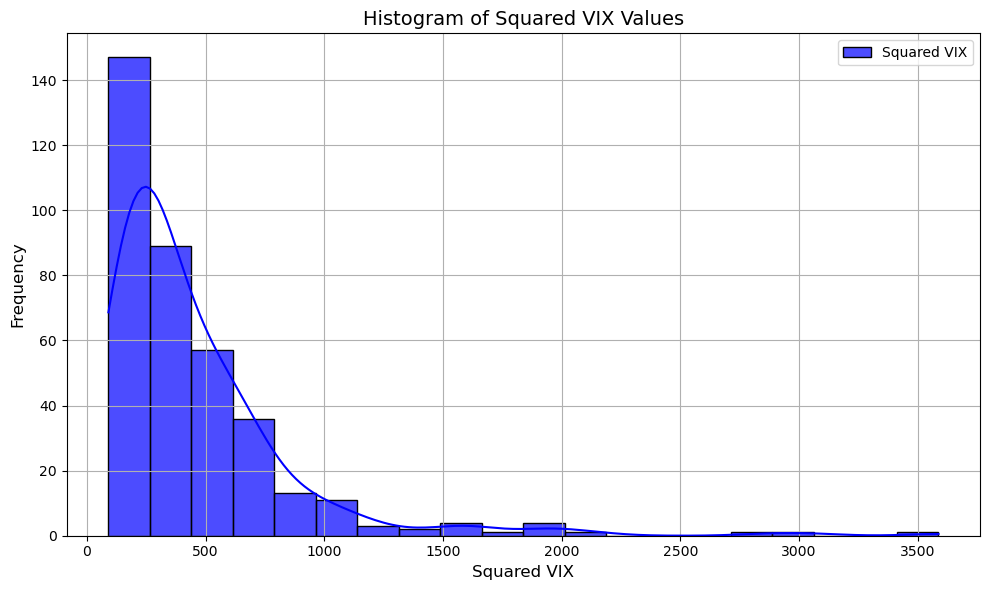

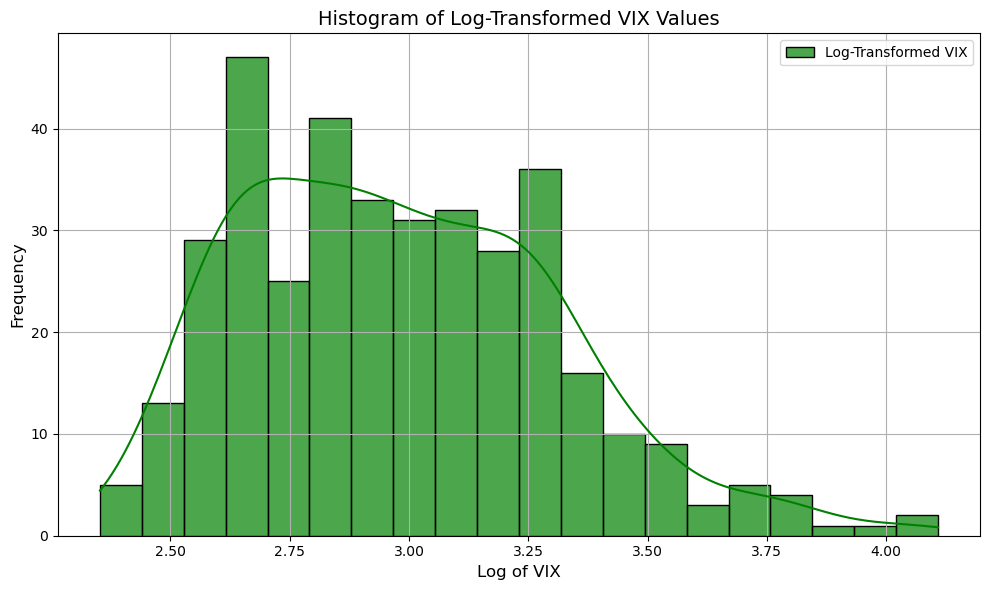

In [83]:
# Histogram for the squared VIX values
plt.figure(figsize=(10, 6))
sns.histplot(df['sq_vix'], bins=20, kde=True, color="blue", alpha=0.7, label="Squared VIX")

# Plot aesthetics
plt.title("Histogram of Squared VIX Values", fontsize=14)
plt.xlabel("Squared VIX", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Log Transformation of VIX
df['log_vix'] = np.log1p(df['vix'])  # Use np.log1p to safely handle zeros

# Plot histogram of the log-transformed variable
plt.figure(figsize=(10, 6))
sns.histplot(df['log_vix'], bins=20, kde=True, color="green", alpha=0.7, label="Log-Transformed VIX")

# Plot aesthetics
plt.title("Histogram of Log-Transformed VIX Values", fontsize=14)
plt.xlabel("Log of VIX", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Regression models with different transformations 
We ran regressions with the dependent variable and explanatory variables in multiple forms (raw, log-log, first differences, percentage returns, and log returns). The results showed:

- The log-log model had reduced variance, resulting in a more linear relationship and had the highest r-squared (0.815), indicating a strong fit but lacked stationarity.
  
- The percentage returns and log returns models both had similar r-squared values (0.315 and 0.298, respectively) and significant results. Furthermore, the percentage return transformation provided the best fit in the relationship between the dependent variable and VIX. 

- The raw values model and first difference model were not chosen due to lower interpretability and lack of alignment with the study’s focus on relative changes.


In [86]:
# --- Raw Regression ---
# This model uses raw data values without any transformation.
reg_raw = smf.ols("sp500_energy ~ crude_oil_prices + vix", data=df).fit(cov_type="HC0")

# --- Log-Log Regression ---
# This model uses log-transformed data for dependent and independent variables.
reg_log_log = smf.ols("ln_energy ~ ln_oil + ln_vix", data=df).fit(cov_type="HC0")

# --- First Difference Regression ---
# This model uses the first difference of variables to account for stationarity.
reg_diff = smf.ols("d_energy ~ d_oil + d_vix", data=df).fit(cov_type="HC0")

# --- Percentage Returns Regression ---
# This model uses percentage returns as independent variables.
reg_pct = smf.ols("PctRetEnergy ~ PctRetOil + PctRetVix", data=df).fit(cov_type="HC0")

# --- Log Return Regression ---
# This model uses log differences (log returns) as independent variables.
reg_log_return = smf.ols("d_ln_energy ~ d_ln_oil + d_ln_vix", data=df).fit(cov_type="HC0")

# --- Create a Summary Table ---
# Combine the results of all models into a Stargazer table for comparison.
stargazer = Stargazer([reg_raw, reg_log_log, reg_diff, reg_pct, reg_log_return])
stargazer.title("Regression Results")
stargazer.custom_columns(
    ["Raw", "Log-Log", "First Difference", "Percentage Returns", "Log Return"], 
    [1, 1, 1, 1, 1]
)
stargazer.show_model_numbers(True)

# Print the Stargazer table
stargazer

## Stationarity
After stationarity testing with the Augmented Dickey-Fuller (ADF) test, we found that the log-transformed variables were not stationary. VIX was stationary even in its raw form due to its mean convergence tendency. Both percentage returns and log returns were stationary, with percentage returns selected for the final model due to a slightly higher r-squared and better predictive accuracy. 

In [89]:
def check_stationarity(df):
    """
    Perform stationarity checks for each numerical column in the DataFrame
    using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        None: Prints the results of the stationarity test for each variable.
    """
    results = []
    excluded_columns = ['date', 'sentiment_category', 'post_2015', 'sentiment_category_full']  # Columns to skip
    for column in df.columns:
        if column not in excluded_columns:
            result = adfuller(df[column].dropna())  # Perform ADF test
            adf_stat = result[0]
            p_value = result[1]
            conclusion = 'Stationary' if p_value < 0.05 else 'Not Stationary'
            results.append({
                'Variable': column,
                'ADF Statistic': adf_stat,
                'p-value': p_value,
                'Conclusion': conclusion
            })
    
    # Print results
    for res in results:
        print(f"Variable: {res['Variable']}")
        print(f"  ADF Statistic: {res['ADF Statistic']:.4f}")
        print(f"  p-value: {res['p-value']:.4f}")
        print(f"  Conclusion: {res['Conclusion']}")
        print("-" * 30)

# Run the function on your DataFrame
check_stationarity(df)

Variable: crude_oil_prices
  ADF Statistic: -2.3067
  p-value: 0.1698
  Conclusion: Not Stationary
------------------------------
Variable: interest_rates
  ADF Statistic: -3.1492
  p-value: 0.0231
  Conclusion: Stationary
------------------------------
Variable: reer_exchange
  ADF Statistic: -2.0538
  p-value: 0.2635
  Conclusion: Not Stationary
------------------------------
Variable: consumption_expenditure
  ADF Statistic: -1.9391
  p-value: 0.3139
  Conclusion: Not Stationary
------------------------------
Variable: cpi
  ADF Statistic: -1.9724
  p-value: 0.2988
  Conclusion: Not Stationary
------------------------------
Variable: vix
  ADF Statistic: -3.4806
  p-value: 0.0085
  Conclusion: Stationary
------------------------------
Variable: sp500_energy
  ADF Statistic: -1.3941
  p-value: 0.5851
  Conclusion: Not Stationary
------------------------------
Variable: Unnamed: 0_x
  ADF Statistic: 3.7337
  p-value: 1.0000
  Conclusion: Not Stationary
------------------------------
V

A simple regression analysis showed that VIX alone had a higher than oil returns, suggesting a stronger relationship with the S&P 500 Energy Index. When both variables were included, the increased to 0.315, and the slope of oil returns decreased, highlighting the presence of omitted variable bias in models that excluded VIX. 

In [92]:
# --- Single Variable Models ---
# Linear regression for each predictor variable individually
reg0 = smf.ols("PctRetEnergy ~ PctRetOil", data=df).fit(cov_type="HC0")
reg1 = smf.ols("PctRetEnergy ~ PctRetVix", data=df).fit(cov_type="HC0")

# --- Combined Model ---
# Linear regression with both predictors included
reg2 = smf.ols("PctRetEnergy ~ PctRetOil + PctRetVix", data=df).fit(cov_type="HC0")

# Create a Stargazer summary table for comparison
stargazer2 = Stargazer([reg0, reg1, reg2])
stargazer2.title("Regression Models Comparing PctRetOil and PctRetVix")
stargazer2.custom_columns(["PctRetOil", "PctRetVix", "Combined"], [1, 1, 1])
stargazer2.show_model_numbers(True)

# Print the Stargazer table
stargazer2

## Explanatory vs. Control Variables - checking correlation, multicollinearity and serial correlation
To assess overlap between explanatory and control variables, we conducted simple linear regressions using each control variable as the dependent variable. The results showed minimal overlap, with the highest relationship being between crude oil prices and CPI (r-squared = 0.44).

In [95]:
# X Variables (predictors)
x_vars = ['crude_oil_prices', 'vix']
# Z Variables (dependent variables)
z_vars = ['interest_rates', 'reer_exchange', 'consumption_expenditure', 'cpi', 'Quantity', 'sentiment_num']
# --- Analyze Relationships ---
results = []
# Loop through all combinations of X and Z variables
for x in x_vars:
    for z in z_vars:
        # Create regression formula
        formula = f"{z} ~ {x}"
        
        # Fit the model using Ordinary Least Squares (OLS)
        model = smf.ols(formula, data=df).fit()
        
        # Append results with adjusted R-squared and p-value
        results.append({
            "X Variable": x,
            "Z Variable": z,
            "Adj R-squared": model.rsquared_adj,
            "p-value": model.f_pvalue
        })
# Display the relationship strength and significance for each pair of X and Z
for result in results:
    print(f"Relationship between {result['X Variable']} and {result['Z Variable']}:")
    print(f"  Adj R-squared: {result['Adj R-squared']:.4f}")
    print(f"  p-value: {result['p-value']:.4e}")
    print("-" * 30)

Relationship between crude_oil_prices and interest_rates:
  Adj R-squared: 0.2065
  p-value: 1.6127e-20
------------------------------
Relationship between crude_oil_prices and reer_exchange:
  Adj R-squared: 0.0865
  p-value: 4.6361e-09
------------------------------
Relationship between crude_oil_prices and consumption_expenditure:
  Adj R-squared: 0.4394
  p-value: 1.6030e-48
------------------------------
Relationship between crude_oil_prices and cpi:
  Adj R-squared: 0.4381
  p-value: 2.4602e-48
------------------------------
Relationship between crude_oil_prices and Quantity:
  Adj R-squared: -0.0023
  p-value: 4.5117e-01
------------------------------
Relationship between crude_oil_prices and sentiment_num:
  Adj R-squared: 0.3127
  p-value: 7.3390e-11
------------------------------
Relationship between vix and interest_rates:
  Adj R-squared: 0.0136
  p-value: 1.4010e-02
------------------------------
Relationship between vix and reer_exchange:
  Adj R-squared: 0.0191
  p-value

**Variance Inflation Factor (VIF) analysis** was performed to check for multicollinearity. High multicollinearity makes it difficult to estimate coefficients accurately, as the model cannot distinguish the unique effect of each predictor. High VIF values were observed for REER, CPI, quantity, and consumption expenditure. Due to high correlation (~0.95) between CPI and consumption expenditure, the latter was dropped.


In [98]:
# Select columns to check for multicollinearity
X = df[['crude_oil_prices', 'vix', 'interest_rates', 'cpi', 'reer_exchange', 'Quantity', 'sentiment_num']]
# Temporarily fill missing values for VIF calculation
X_imputed = X.fillna(0)
# --- Calculate VIF ---
vif_data = pd.DataFrame()
vif_data["Variable"] = X_imputed.columns
vif_data["VIF"] = [variance_inflation_factor(X_imputed.values, i) for i in range(X_imputed.shape[1])]
# Print the VIF results
print(vif_data)

           Variable         VIF
0  crude_oil_prices   12.026131
1               vix    8.933337
2    interest_rates    4.625362
3               cpi  150.315327
4     reer_exchange  112.225600
5          Quantity    7.937391
6     sentiment_num    1.193315


**Correlation Analysis** helps us identify possible redundancies or confounding effects in the regression, and it revealed that CPI and REER had a correlation of 0.66, which, while notable, was not severe enough to cause multicollinearity. Stationarity checks revealed non-stationarity for both CPI and REER. First differences were applied to address this issue.

Explanation for Correlation:

**REER and CPI:** The REER incorporates inflation adjustments, as it measures a country’s currency value relative to a basket of foreign currencies, adjusted for price differences. This naturally leads to correlation with CPI

**
Interest Rates and PII**: Te negativeh correlation is due to monetary policy, where central banks adjust interest rates to control inflation, which CPI measures directl

**Quantity and Sentiment:** Significant events that impact the quantity of imports—such as geopolitical disruptions, trade policy changes, natural disasters, or major supply chain interruptions—often draw intense media attention.



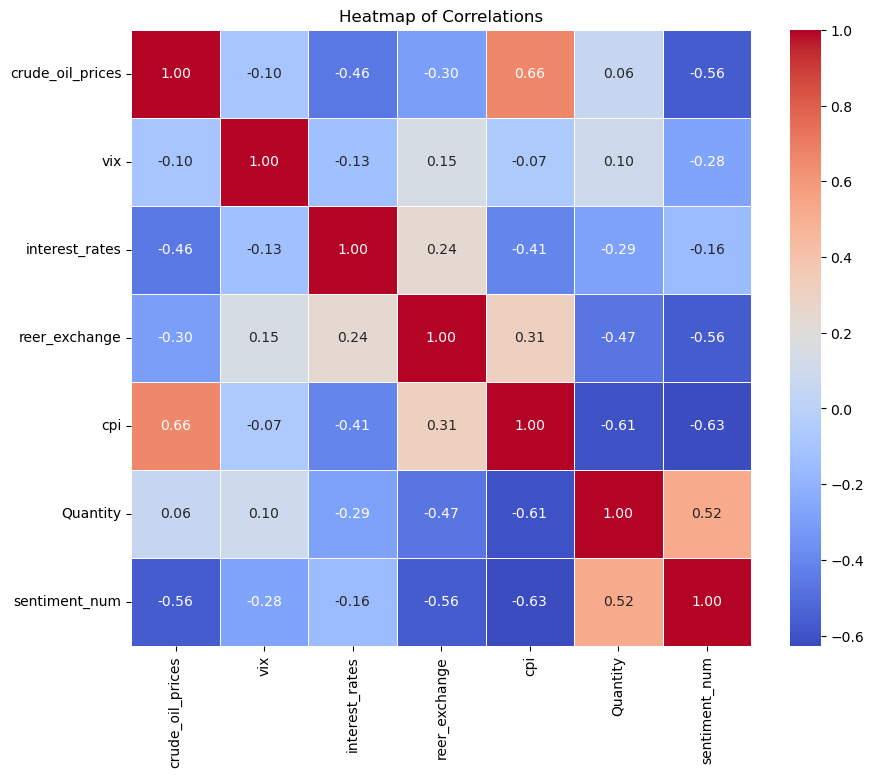

In [101]:
# Compute and visualize correlation matrix for selected variables
heatmap_vars = ['crude_oil_prices', 'vix', 'interest_rates', 'reer_exchange', 'cpi', 'Quantity', 'sentiment_num']
correlation_matrix = df[heatmap_vars].corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Correlations')
plt.show()
# Results show high correlations between variables (e.g., CPI, REER, and interest rates) may indicate multicollinearity.
# This can affect regression models, necessitating additional checks like VIF.

In [107]:
# After rechecking Stationaity we found that both variables have trend so we took the first difference and reran the VIF 
df = df.dropna(subset=["reer_exchange_diff", "cpi_diff"])
vars_for_vif = df[['PctRetOil', 'PctRetVix', 'interest_rates', 'cpi_diff','reer_exchange_diff']]
vif_data = pd.DataFrame()
vif_data["Variable"] = vars_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(vars_for_vif.values, i) for i in range(vars_for_vif.shape[1])]

print(vif_data)
# The VIF now does not indicate multicollinearity

             Variable       VIF
0           PctRetOil  1.386874
1           PctRetVix  1.009290
2      interest_rates  1.265146
3            cpi_diff  1.551533
4  reer_exchange_diff  1.101803


## Testing for Unit Root 
Next, we check for Unit-Root on the transformed variables using the Phillips-perron test, which revealed that interest rates was not stationary despite a contradicting conclusion form the ADF test, to investigate this further I plotted the residuals diagnostics (ACF & PACF), then I used the Zivot-Andrews test for structural breaks which revealed that we have a unit roots with a structural break. A structural break can mean that there was a significant shift in the underlying trend or variability of inflation, likely caused by an external event like a policy change or economic shock. So, we took the first difference to address this. 

           Variable  phillips_perron    Stationarity
0  crude_oil_prices     4.408951e-01  Non-Stationary
1               vix     2.332432e-09      Stationary
2    interest_rates     2.450357e-01  Non-Stationary
3               cpi     4.877861e-02      Stationary
4     reer_exchange     2.433703e-01  Non-Stationary
5          Quantity     2.104826e-01  Non-Stationary
6     sentiment_num     5.295191e-13      Stationary
             Variable  phillips_perron    Stationarity
0        PctRetEnergy     0.000000e+00      Stationary
1           PctRetOil     3.125656e-25      Stationary
2           PctRetVix     0.000000e+00      Stationary
3      interest_rates     2.450357e-01  Non-Stationary
4            cpi_diff     5.812369e-22      Stationary
5  reer_exchange_diff     1.325444e-23      Stationary
6       quantity_diff     0.000000e+00      Stationary
7       sentiment_num     5.295191e-13      Stationary


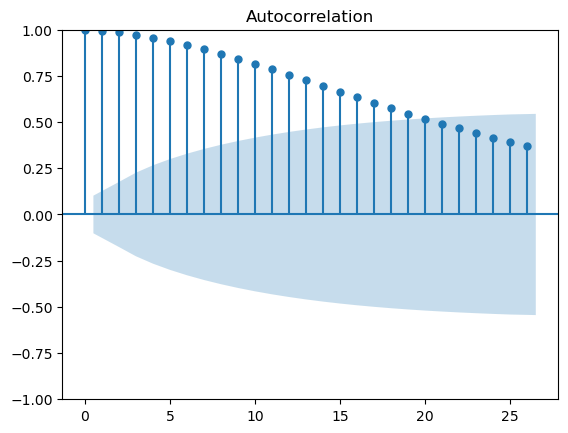

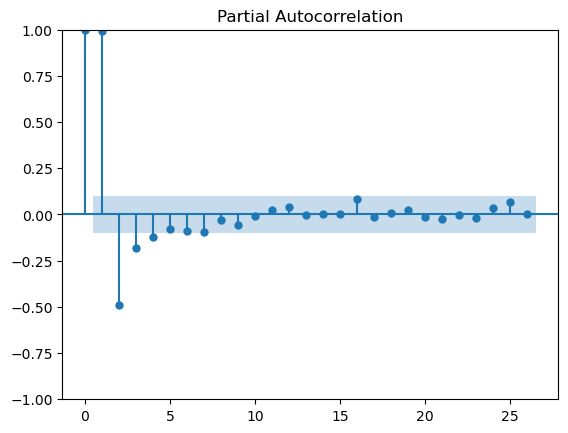

<bound method UnitRootTest.summary of <class 'arch.unitroot.unitroot.ZivotAndrews'>
"""
        Zivot-Andrews Results        
Test Statistic                 -4.911
P-value                         0.039
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -5.28 (1%), -4.81 (5%), -4.57 (10%)
Null Hypothesis: The process contains a unit root with a single structural break.
Alternative Hypothesis: The process is trend and break stationary.
""">


In [110]:
# Unit Root Testing: Original Columns
X_original = df[['crude_oil_prices', 'vix', 'interest_rates', 'cpi', 'reer_exchange', 'Quantity', 'sentiment_num']].fillna(0)
unitroot_data = pd.DataFrame()
unitroot_data["Variable"] = X_original.columns
unitroot_data["phillips_perron"] = [PhillipsPerron(X_original[col]).pvalue for col in X_original.columns]
unitroot_data["Stationarity"] = ["Stationary" if p < 0.05 else "Non-Stationary" for p in unitroot_data["phillips_perron"]]
print(unitroot_data)
# Unit Root Testing: Transformed Columns
X_transformed = df[['PctRetEnergy', 'PctRetOil', 'PctRetVix', 'interest_rates', 'cpi_diff', 'reer_exchange_diff', 'quantity_diff', 'sentiment_num']].fillna(0)
unitroot_data = pd.DataFrame()
unitroot_data["Variable"] = X_transformed.columns
unitroot_data["phillips_perron"] = [PhillipsPerron(X_transformed[col]).pvalue for col in X_transformed.columns]
unitroot_data["Stationarity"] = ["Stationary" if p < 0.05 else "Non-Stationary" for p in unitroot_data["phillips_perron"]]
print(unitroot_data)
# Diagnostics for 'interest_rates'
# ACF and PACF plots
plot_acf(df['interest_rates'].dropna())
plot_pacf(df['interest_rates'].dropna())
plt.show()
# Zivot-Andrews test for structural breaks
za_test = ZivotAndrews(df['interest_rates'].dropna())
print(za_test.summary)
# This suggests that we have a unit root possiblue due to external policies introducing a trend 
# Apply first difference to eliminate unit root 
df["interest_rates_diff"] = df["interest_rates"].diff()

## Modelling 

We developed five models: a baseline model, a full model, an interaction model, and two robustness checks. 
The baseline model focused on the percentage return of oil and VIX, both of which were highly significant (p < 0.001). The full model included additional controls, such as sentiment categories, with neutral sentiment as the reference. While the sentiment coefficients provided some insight into potential relationships—negative sentiment (-0.546) had a slight negative effect, and positive sentiment (0.713) a small positive effect—none of these were statistically significant. The explanatory power of the percentage return of oil and VIX persisted, though their coefficients decreased slightly, as expected with the inclusion of more variables. Among the controls, the REER exchange difference was the only significant variable (-0.755, p < 0.01), potentially reflecting the impact of a stronger dollar on energy sector competitiveness in global markets, as a stronger dollar makes exports costlier and energy prices more sensitive to exchange rate fluctuations. The interaction model showed similar patterns but introduced an intriguing shift: the coefficient for positive sentiment turned negative (-0.3), and the interaction between oil and VIX returns (-0.006, p < 0.05) suggested a compounding, though moderate, negative effect. Other interaction terms, such as those involving the quantity difference, sentiment categories, and REER differences, were not significant. The interaction model stood out with the highest R^2 (0.431) and adjusted R^2 (0.405), as well as the lowest residual standard error, making it the most explanatory model overall. 

In [17]:
# --- Baseline Model ---
# This model includes only the primary explanatory variables: PctRetOil and PctRetVix.
model_1 = smf.ols(
    formula="""PctRetEnergy ~ PctRetOil + PctRetVix""",
    data=df
).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# --- Full Model ---
# Includes additional control variables like CPI difference, interest rates, REER difference, and sentiment categories.
model_2 = smf.ols(
    formula="""PctRetEnergy ~ PctRetOil + PctRetVix + cpi_diff + interest_rates_diff + reer_exchange_diff + 
               quantity_diff_full + C(sentiment_category_full, Treatment(reference="Neutral"))""",
    data=df
).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# --- Interaction Model ---
# Adds interaction terms between key predictors and sentiment or quantity differences.
model_3 = smf.ols(
    formula="""PctRetEnergy ~ PctRetOil + PctRetVix + cpi_diff + interest_rates_diff + reer_exchange_diff +
               quantity_diff_full + C(sentiment_category_full, Treatment(reference="Neutral")) +
               PctRetOil:PctRetVix + PctRetOil:sentiment_category_full + 
               PctRetOil:quantity_diff_full + cpi_diff:quantity_diff_full + 
               PctRetVix:reer_exchange_diff""",
    data=df
).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# --- Robustness Check 1 ---
# Focuses on the relationship between quantity differences and percentage returns.
model_4 = smf.ols(
    formula="""PctRetEnergy ~ quantity_diff_full + PctRetOil:quantity_diff_full + cpi_diff:quantity_diff_full""",
    data=df
).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# --- Robustness Check 2 ---
# Includes key predictors and interaction terms with REER differences.
model_5 = smf.ols(
    formula="""PctRetEnergy ~ PctRetOil + PctRetVix + PctRetOil:PctRetVix + 
               PctRetVix:reer_exchange_diff""",
    data=df
).fit(cov_type='HAC', cov_kwds={'maxlags': 1})

# --- Summary of Models ---
stargazer3 = Stargazer([model_1,model_2,model_3,model_4,model_5])
stargazer3.title("Regression Models with Robust Standard Errors")
stargazer3.custom_columns(["Baseline", "Full Model", "Interaction Model", "Robustness 1", "Robustness 2"], [1, 1, 1, 1, 1])
stargazer3

## models with different standard errors formulas and introducing lags 

To explore the choice of lags for the interaction model, I tested the model using normal standard errors and HAC standard errors, which account for both autocorrelation and heteroscedasticity. For robustness, I applied these methods across three variations of the model, each with an increasing lag. Interestingly, the R-squared and adjusted R-squared values, as well as the number of significant coefficients, remained consistent across these models, offering no clear basis for selecting a specific lag structure. Given this, I chose to use HAC standard errors for their robustness and reliability in handling autocorrelation and heteroscedasticity.

In [18]:
# Baseline Interaction Model
model_a = smf.ols(
    formula="""PctRetEnergy ~ PctRetOil + PctRetVix + cpi_diff + interest_rates_diff + reer_exchange_diff +
               quantity_diff_full + C(sentiment_category_full, Treatment(reference="Neutral")) +
               PctRetOil:PctRetVix + PctRetOil:sentiment_category_full + 
               PctRetOil:quantity_diff_full + cpi_diff:quantity_diff_full + 
               PctRetVix:reer_exchange_diff""",
    data=df
).fit()
# Interaction Model with HAC Robust Covariance (1 Lag)
model_b = smf.ols(
    formula="""PctRetEnergy ~ PctRetOil + PctRetVix + cpi_diff + interest_rates_diff + reer_exchange_diff +
               quantity_diff_full + C(sentiment_category_full, Treatment(reference="Neutral")) +
               PctRetOil:PctRetVix + PctRetOil:sentiment_category_full + 
               PctRetOil:quantity_diff_full + cpi_diff:quantity_diff_full + 
               PctRetVix:reer_exchange_diff""",
    data=df
).fit().get_robustcov_results(cov_type="HAC", maxlags=1)
# Interaction Model with HAC Robust Covariance (2 Lag)
model_c = smf.ols(
    formula="""PctRetEnergy ~ PctRetOil + PctRetVix + cpi_diff + interest_rates_diff + reer_exchange_diff +
               quantity_diff_full + C(sentiment_category_full, Treatment(reference="Neutral")) +
               PctRetOil:PctRetVix + PctRetOil:sentiment_category_full + 
               PctRetOil:quantity_diff_full + cpi_diff:quantity_diff_full + 
               PctRetVix:reer_exchange_diff""",
    data=df
).fit().get_robustcov_results(cov_type="HAC", maxlags=2)
# Interaction Model with HAC Robust Covariance (3 Lag)
model_d = smf.ols(
    formula="""PctRetEnergy ~ PctRetOil + PctRetVix + cpi_diff + interest_rates_diff + reer_exchange_diff +
               quantity_diff_full + C(sentiment_category_full, Treatment(reference="Neutral")) +
               PctRetOil:PctRetVix + PctRetOil:sentiment_category_full + 
               PctRetOil:quantity_diff_full + cpi_diff:quantity_diff_full + 
               PctRetVix:reer_exchange_diff""",
    data=df
).fit().get_robustcov_results(cov_type="HAC", maxlags=3)
# Print summaries for comparison
print(model_a.summary())
print(model_b.summary())
print(model_c.summary())
print(model_d.summary())

                            OLS Regression Results                            
Dep. Variable:           PctRetEnergy   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     16.64
Date:                Mon, 30 Dec 2024   Prob (F-statistic):           3.11e-34
Time:                        00:32:43   Log-Likelihood:                -1128.1
No. Observations:                 369   AIC:                             2290.
Df Residuals:                     352   BIC:                             2357.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

## REER lags 
I then updated the model to include lags for the REER exchange difference, suspecting that the variable might exert an effect over time. The inclusion of these lags improved the model’s explanatory power, with the R-squared increasing to 0.444. The first lag showed a steeper negative slope than the intial REER and was statistically significant, suggesting a delayed but substantial impact of exchange rate changes on the energy index. Interestingly, the second lag turned positive and was also significant, indicating a reversal or compensatory effect in later periods. These findings highlight the importance of accounting for lagged effects to capture the propagation and cumulative dynamics of exchange rate fluctuations over time.

In [123]:
# Updated Model to Include REER Lags
formula = """PctRetEnergy ~ PctRetOil + PctRetVix + cpi_diff + interest_rates_diff +
             reer_exchange_diff + reer_exchange_diff_lag1 + reer_exchange_diff_lag2 +
             quantity_diff_full + C(sentiment_category_full, Treatment(reference="Neutral")) +
             PctRetOil:PctRetVix + PctRetOil:sentiment_category_full + 
             PctRetOil:quantity_diff_full + cpi_diff:quantity_diff_full + 
             PctRetVix:reer_exchange_diff"""
# Fit the model with HAC robust standard errors (2 lags)
model_with_lags = smf.ols(formula=formula, data=df).fit(cov_type='HAC', cov_kwds={'maxlags': 2})
model_with_lags.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           PctRetEnergy   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     9.584
Date:                Mon, 30 Dec 2024   Prob (F-statistic):           1.05e-20
Time:                        13:53:30   Log-Likelihood:                -1121.2
No. Observations:                 368   AIC:                             2280.
Df Residuals:                     349   BIC:                             2355.
Df Model:                          18                                         
Covariance Type:                  HAC                                         
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  0.7773      0.845      0.920      0.358      -0.879       2.433
C(sentiment_category_full, Treatment(reference="Neutral"))[T.NA]          -1.2040      0.841     -1.432      0.152      -2.852       0.444
C(sentiment_category_full, Treatment(reference="Neutral"))[T.Negative]    -1.5247      1.429     -1.067      0.286      -4.326       1.276
C(sentiment_category_full, Treatment(reference="Neutral"))[T.Positive]    -0.4023      0.948     -0.425      0.671      -2.260       1.455
PctRetOil                                                                  0.2136      0.051      4.184      0.000       0.114       0.314
PctRetOil:sentiment_category_full[T.Negative]                              0.0275      0.147      0.188      0.851      -0.260       0.315
PctRetOil:sentiment_category_full[T.Neutral]                               0.2706      0.214      1.265      0.206      -0.149       0.690
PctRetOil:sentiment_category_full[T.Positive]                              0.0544      0.096      0.565      0.572      -0.134       0.243
PctRetVix                                                                 -0.1164      0.018     -6.520      0.000      -0.151      -0.081
cpi_diff                                                                  -0.3170      0.632     -0.502      0.616      -1.555       0.921
interest_rates_diff                                                        0.8721      1.455      0.599      0.549      -1.980       3.724
reer_exchange_diff                                                        -0.4521      0.263     -1.719      0.086      -0.968       0.063
reer_exchange_diff_lag1                                                   -0.5731      0.287     -2.000      0.046      -1.135      -0.011
reer_exchange_diff_lag2                                                    0.6558      0.257      2.556      0.011       0.153       1.159
quantity_diff_full                                                     -5.218e-07    5.4e-07     -0.967      0.334   -1.58e-06    5.36e-07
PctRetOil:PctRetVix                                                       -0.0053      0.003     -2.081      0.037      -0.010      -0.000
PctRetOil:quantity_diff_full                                           -8.171e-09   6.48e-08     -0.126      0.900   -1.35e-07    1.19e-07
cpi_diff:quantity_diff_full                                            -1.229e-06   9.04e-07     -1.360      0.174      -3e-06    5.42e-07
PctRetVix:reer_exchange_diff                                               0.0132      0.016      0.831      0.406      -0.018       0.044
=========================

## checking multicollinearity, serial correlation and cumulative effects

The chosen model underwent further diagnostic checks to confirm its robustness and ensure that the assumptions of regression analysis were met. To assess multicollinearity, we applied the Variance Inflation Factor (VIF), which showed that all variables in the model had a VIF below 1.5. This indicates minimal multicollinearity, despite initial concerns raised by the condition number in earlier tests. Additionally, the Durbin-Watson statistic was calculated to test for serial correlation in the residuals, yielding a value of 2.38. This value is close to 2, confirming the absence of serial correlation and reinforcing the reliability of the model.

To further understand the long-term impact of the REER exchange lags, we calculated the cumulative effect across the lags. The cumulative effect of REER on the percentage return of the S&P 500 Energy Index was found to be -0.369. This indicates that, over time, fluctuations in exchange rates exert a moderately negative cumulative influence on the energy index’s returns. Such an effect underscores the sensitivity of the energy sector to exchange rate movements, as they can affect trade competitiveness and the valuation of energy exports in global markets. These diagnostic checks validate the model’s integrity and offer deeper insights into the temporal dynamics of the variables.

In [20]:
# --- Variance Inflation Factor (VIF) Analysis ---
X = df[['PctRetEnergy', 'PctRetOil', 'PctRetVix', 'cpi_diff','interest_rates_diff', 'reer_exchange_diff','reer_exchange_diff_lag1','reer_exchange_diff_lag2',
'quantity_diff_full','sentiment_num']]
X_imputed = X.fillna(0)  # temporary null imputation 
vif_data = pd.DataFrame()
vif_data["Variable"] = X_imputed.columns
vif_data["VIF"] = [variance_inflation_factor(X_imputed.values, i) for i in range(X_imputed.shape[1])]
print(vif_data)
# --- Durbin-Watson statistic for serial correlation in residuals ---
dw_stat = durbin_watson(model_with_lags.resid)
print(f"Durbin-Watson Statistic: {dw_stat}")
# Explanation:
# - Durbin-Watson statistic checks for serial correlation in residuals.
# - Values near 2 indicate no serial correlation.
# - Values < 2 suggest positive autocorrelation; values > 2 suggest negative autocorrelation.
# - In this case, DW = 2.38 indicates no significant serial correlation.

# ---  Cumulative REER Effect Calculation ---
# Extract coefficients for REER difference and its lags from the fitted model and sum them up
coeffs = model_with_lags.params.loc[['reer_exchange_diff', 'reer_exchange_diff_lag1', 'reer_exchange_diff_lag2']]
cumulative_effect = coeffs.sum()
print("REER Coefficients:\n", coeffs)
print("Cumulative Effect:", cumulative_effect)

                  Variable       VIF
0             PctRetEnergy  1.538442
1                PctRetOil  1.543482
2                PctRetVix  1.311502
3                 cpi_diff  1.320633
4      interest_rates_diff  1.122533
5       reer_exchange_diff  1.294377
6  reer_exchange_diff_lag1  1.469991
7  reer_exchange_diff_lag2  1.224877
8       quantity_diff_full  1.028268
9            sentiment_num  1.053514
Durbin-Watson Statistic: 2.3826656539103617
REER Coefficients:
 reer_exchange_diff        -0.452087
reer_exchange_diff_lag1   -0.573087
reer_exchange_diff_lag2    0.655753
dtype: float64
Cumulative Effect: -0.3694215743582503


## Predictive Fan charts 

In [21]:
# set date as index for plotting purposes
df.set_index('date', inplace=True)

### Fan Chart - Predict Future S&P 500 Energy Index
The fan chart illustrates the predicted trajectory of the S&P 500 Energy Index over the next 12 months, holding all other variables constant. The predictions were derived by reverse-engineering the raw prices from the percentage returns produced by the model, with a 95% confidence interval to represent the uncertainty in these forecasts. The blue line represents historical values, the red line shows predicted values, and the gray shaded area captures the confidence interval.

The chart shows a slight downward trend in the index, indicating a potential decline in energy sector performance based on the model’s current structure. The widening of the confidence interval over time reflects growing uncertainty in the predictions as we look further into the future. In the zoomed-in version, which focuses on data from 2020 onward, recent trends are more evident, and the stabilization of predictions in 2024 becomes clearer.

These predictions provide valuable insights into the energy index’s short-term movements while emphasizing that they are conditional on the assumption that all other variables remain constant. This caveat highlights the importance of interpreting the results within the context of the model’s design and limitations.

In [22]:
# Step 1: Sort DataFrame and define the last historical value
df = df.sort_index(ascending=True)  # Ensure chronological order
P_last = df['sp500_energy'].iloc[-1]  # Last observed value

# Step 2: Generate predictions with a 95% confidence interval
predictions = model_with_lags.get_prediction(df).summary_frame(alpha=0.05)

# Limit to the next 12 periods for future predictions
future_periods = 12
predictions = predictions.head(future_periods)  # Take only the first 12 predictions

# Step 3: Reverse-engineer raw predicted prices from percentage returns
predicted_raw_values = [P_last]  # Initialize with the last known value
for pred_return in predictions['mean']:
    next_value = predicted_raw_values[-1] * (1 + pred_return / 100)  # Compounding
    predicted_raw_values.append(next_value)
predicted_raw_values = predicted_raw_values[1:]  # Remove the initial value to avoid duplication

# Add predicted raw values to the predictions DataFrame
predictions['PredictedRawValue'] = predicted_raw_values

# Step 4: Create future dates for predictions
last_date = df.index[-1]
future_dates = pd.date_range(
    start=last_date + pd.offsets.MonthBegin(1),
    periods=future_periods,
    freq='MS'
)
predictions['FutureDate'] = future_dates

# Step 5: Calculate confidence intervals for predicted values
ci_lower_raw = [predicted_raw_values[0]]
ci_upper_raw = [predicted_raw_values[0]]

# Calculate confidence intervals iteratively
for i in range(1, len(predictions)):
    next_ci_lower = ci_lower_raw[-1] * (1 + predictions['mean_ci_lower'].iloc[i] / 100)
    next_ci_upper = ci_upper_raw[-1] * (1 + predictions['mean_ci_upper'].iloc[i] / 100)
    ci_lower_raw.append(next_ci_lower)
    ci_upper_raw.append(next_ci_upper)

# Add confidence intervals to predictions DataFrame
predictions['CI_Lower_Raw'] = ci_lower_raw
predictions['CI_Upper_Raw'] = ci_upper_raw

# Display predicted values and confidence intervals
print(predictions[['PredictedRawValue', 'CI_Lower_Raw', 'CI_Upper_Raw']])

    PredictedRawValue  CI_Lower_Raw  CI_Upper_Raw
0          702.851373    702.851373    702.851373
1          728.007962    719.261135    736.754788
2          684.399925    654.655237    714.668060
3          666.715336    628.192592    706.623150
4          657.035339    611.282320    705.125856
5          631.541628    577.633764    689.220755
6          643.598131    579.791020    712.962026
7          654.931418    580.112519    737.676150
8          642.046981    561.552103    732.253196
9          639.895164    548.475460    744.396603
10         637.230167    533.806987    758.104372
11         628.334059    518.442877    758.757074


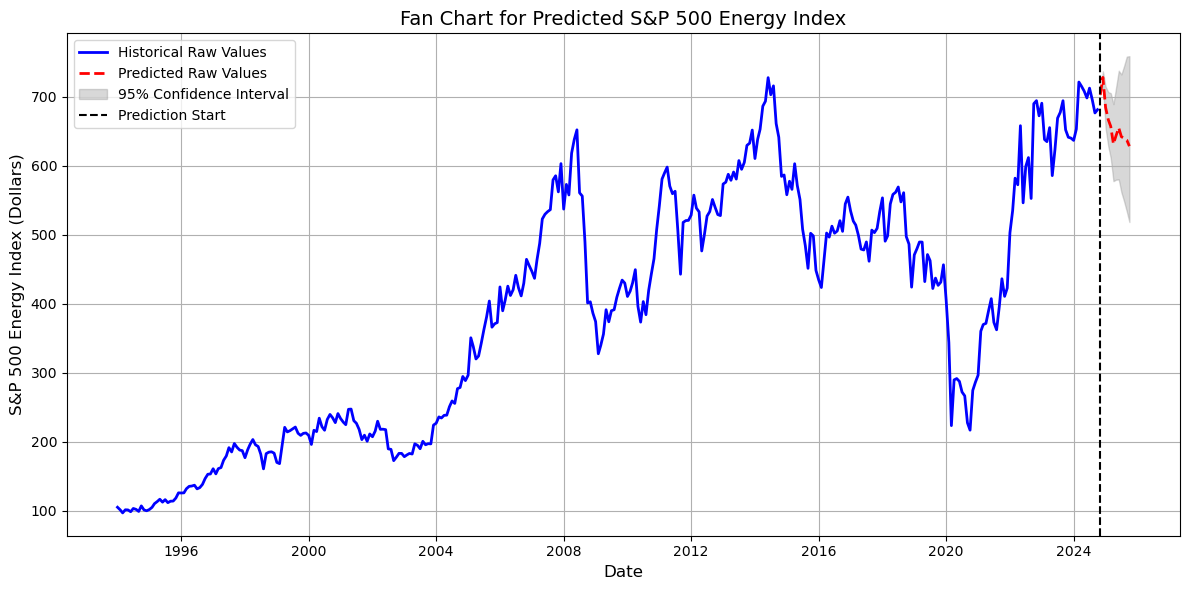

In [23]:
plt.figure(figsize=(12, 6))

# (A) Historical data
plt.plot(df.index, df['sp500_energy'], label="Historical Raw Values", color="blue", linewidth=2)

# (B) Predicted data
plt.plot(future_dates, predicted_raw_values, label="Predicted Raw Values", color="red", linestyle="--", linewidth=2)

# (C) Confidence intervals
plt.fill_between(
    future_dates,
    ci_lower_raw,
    ci_upper_raw,
    color="gray",
    alpha=0.3,
    label="95% Confidence Interval"
)

# (D) Vertical line at prediction start
plt.axvline(x=future_dates[0], color="black", linestyle="--", label="Prediction Start")

# Chart formatting
plt.title("Fan Chart for Predicted S&P 500 Energy Index", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("S&P 500 Energy Index (Dollars)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

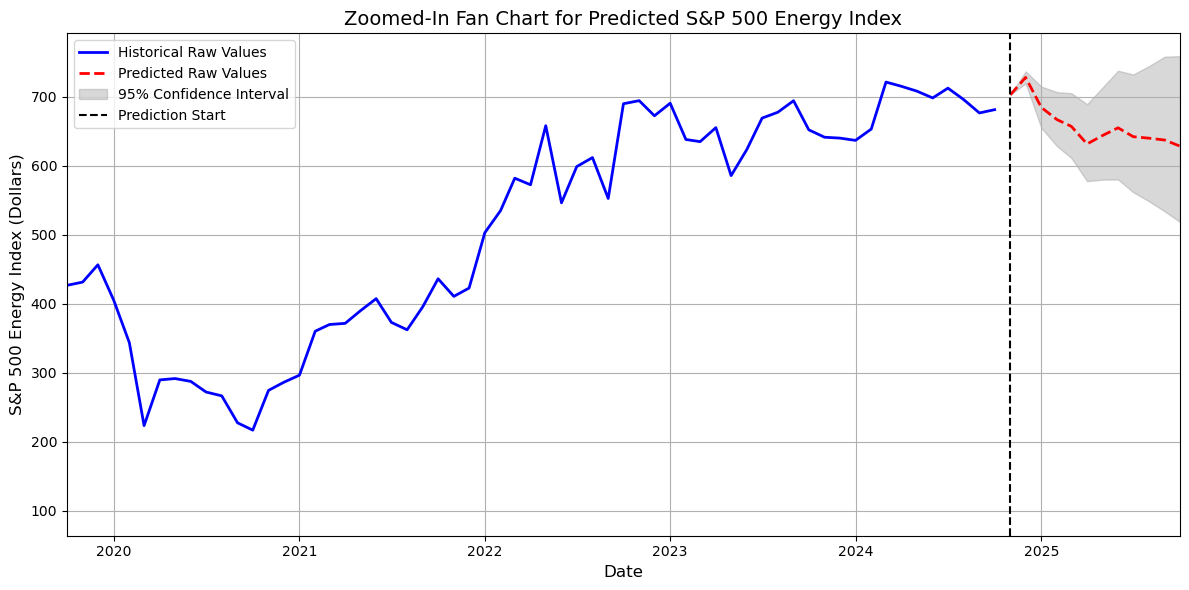

In [24]:
plt.figure(figsize=(12, 6))

# (A) Historical data
plt.plot(df.index, df['sp500_energy'], label="Historical Raw Values", color="blue", linewidth=2)

# (B) Predicted data
plt.plot(future_dates, predicted_raw_values, label="Predicted Raw Values", color="red", linestyle="--", linewidth=2)

# (C) Confidence intervals
plt.fill_between(
    future_dates,
    ci_lower_raw,
    ci_upper_raw,
    color="gray",
    alpha=0.3,
    label="95% Confidence Interval"
)

# (D) Vertical line at prediction start
plt.axvline(x=future_dates[0], color="black", linestyle="--", label="Prediction Start")

# Limit x-axis to show the last 5 years and future predictions
start_zoom_date = last_date - pd.DateOffset(years=5)
plt.xlim([start_zoom_date, future_dates[-1]])

# Chart formatting
plt.title("Zoomed-In Fan Chart for Predicted S&P 500 Energy Index", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("S&P 500 Energy Index (Dollars)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Residual Diagnostics and Normality Check

Residuals vs. Fitted Values:

The Residuals vs. Fitted Values plot is used to assess the assumption of homoscedasticity and to detect potential patterns in the residuals. Ideally, residuals should be randomly scattered around the horizontal zero line without any discernible pattern. In this plot, while many residuals cluster near zero, there is a slight curvature, as shown by the red LOESS line, which deviates from the horizontal line. This indicates a potential nonlinearity in the model that may not be fully captured by the current functional form. Additionally, the spread of residuals appears to increase slightly with larger fitted values, suggesting mild heteroscedasticity, where the variance of the residuals may not be constant across all levels of the fitted values. 

Q-Q Plot of Residuals:

The Q-Q plot assesses whether the residuals follow a normal distribution, which is a key assumption for many statistical tests used in regression analysis. In this plot, the residuals deviate significantly from the red diagonal line, particularly in the tails. This departure suggests that the residuals are not normally distributed, with heavier tails on both ends of the distribution. Such deviations could imply the presence of outliers or non-normality in the data. Despite this non-normality, the use of HAC standard errors in the model ensures that statistical inferences remain robust.


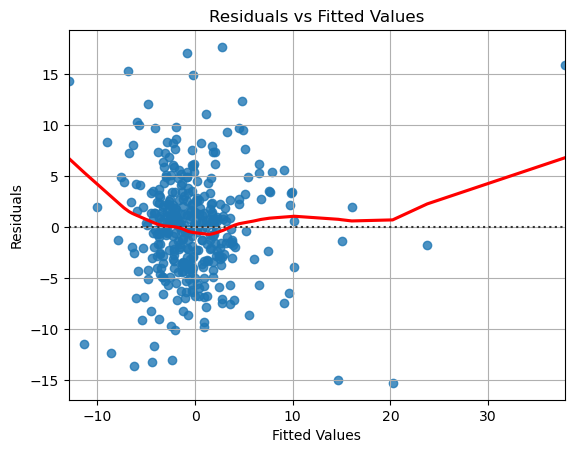

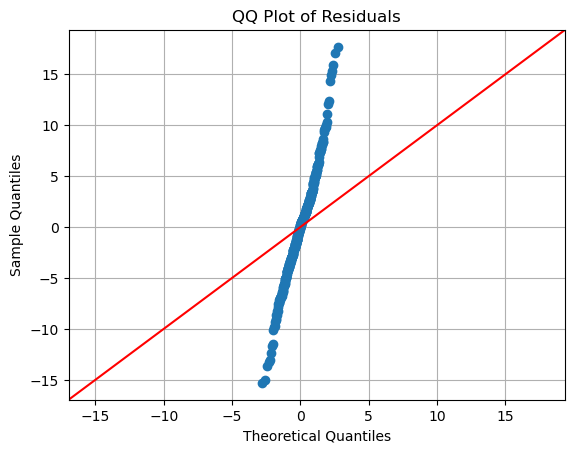

In [25]:
# - The QQ-plot checks if residuals follow a normal distribution. Deviations suggest non-normality.
# - The residual plot ensures there is no systematic pattern, indicating homoscedasticity.

# Residual plot to check the relationship between residuals and fitted values
sns.residplot(x=model_with_lags.fittedvalues, y=model_with_lags.resid, lowess=True, line_kws={"color": "red"})
plt.title("Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()

# QQ-plot to check normality of residuals
sm.qqplot(model_with_lags.resid, line='45')
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()

### Histogram 
The histogram of residuals shows the frequency distribution of the residuals compared to a normal distribution overlaid in red. While the residuals roughly follow a bell-shaped curve, the tails deviate from the normal distribution, with heavier tails on both sides. This suggests that the residuals are not perfectly normally distributed, indicating potential outliers or non-normality in the data. The slight skewness and excess kurtosis in the tails reinforce this observation.


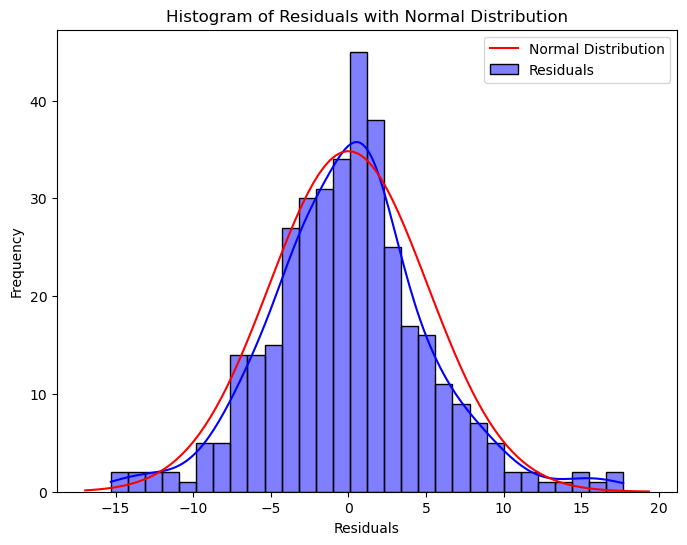

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Assuming `model_with_lags.resid` contains your residuals
plt.figure(figsize=(8, 6))

# Plot the histogram of residuals
sns.histplot(x=model_with_lags.resid, kde=True, bins=30, color='blue', label='Residuals')

# Overlay a normal distribution for comparison
mean = model_with_lags.resid.mean()
std = model_with_lags.resid.std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mean, std)

# Normalize the PDF to match the histogram's scale
scale = len(model_with_lags.resid) * (xmax - xmin) / 30  # Scale by number of bins
plt.plot(x, p * scale, 'r', label='Normal Distribution')

plt.title("Histogram of Residuals with Normal Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The most deviated residuals highlight cases where the model significantly under- or overpredicted, potentially due to unmodeled effects, outliers, or missing explanatory variables. In contrast, the most accurate residuals demonstrate the model’s strength in capturing the overall trends for typical observations, confirming its general reliability while suggesting room for improvement in handling extreme cases.

In [140]:
# Calculate absolute residuals from the model
residuals_abs = model_with_lags.resid.abs()

# Top 5 residuals that deviate the most (largest absolute values)
most_deviated_residuals = residuals_abs.nlargest(5)

# Top 5 residuals that are the most accurate (smallest absolute values)
most_accurate_residuals = residuals_abs.nsmallest(5)

print("Residuals that deviate the most:")
print(model_with_lags.resid[most_deviated_residuals.index])

print("\nResiduals that are the most accurate:")
print(model_with_lags.resid[most_accurate_residuals.index])

Residuals that deviate the most:
340    17.698795
173    17.061971
313    15.928260
257    15.342627
258   -15.306026
dtype: float64

Residuals that are the most accurate:
277   -0.031215
34    -0.037077
287   -0.037858
108    0.039349
135   -0.066236
dtype: float64


## Actual vs Fitted Values 

This plot compares the actual values of the dependent variable with the fitted values predicted by the model. Ideally, the data points should align closely with the red 45-degree line, indicating that the predicted values match the actual values.

In this case, the points cluster near the line, particularly in the center, suggesting that the model predicts well for the majority of observations. However, there are visible deviations, especially for extreme values (outliers), where the points are farther from the 45-degree line. This indicates that the model struggles to accurately predict certain extreme cases, which may reflect unmodeled complexity or outliers in the dataset. Overall, the plot demonstrates decent predictive performance with room for improvement, especially for edge cases.

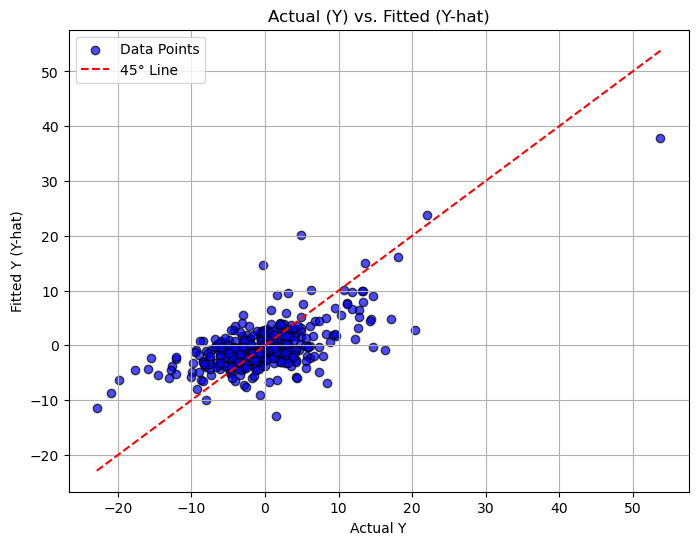

In [26]:
# - Points near the 45° line indicate good model performance.
# - Deviations highlight areas where the model under- or over-predicts.

# Actual values and fitted values from the model
y_actual = model_with_lags.model.endog
y_fitted = model_with_lags.fittedvalues

plt.figure(figsize=(8, 6))

# Scatter plot of actual vs fitted
plt.scatter(y_actual, y_fitted, alpha=0.7, color="blue", edgecolors="k", label="Data Points")

# 45° line for reference (where actual = fitted)
min_val = min(y_actual.min(), y_fitted.min())
max_val = max(y_actual.max(), y_fitted.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="45° Line")

# Plot formatting
plt.title("Actual (Y) vs. Fitted (Y-hat)")
plt.xlabel("Actual Y")
plt.ylabel("Fitted Y (Y-hat)")
plt.legend()
plt.grid(True)
plt.show()

## Predicted vs. Actual values 

The first plot shows the actual versus predicted percentage returns, while the second plot displays the actual versus predicted prices of the S&P 500 Energy Index. Together, they provide a detailed view of how well the model performs in capturing short-term changes (returns) and their cumulative impact on the overall index level (price).

Percentage Returns Plot:

In the percentage return plot, the actual returns (blue) and predicted returns (red) align reasonably well, particularly for most of the smaller fluctuations. However, there are visible discrepancies during periods of extreme market movements, such as around 2008 and 2020, where the model struggles to capture the full magnitude of the spikes. These deviations highlight the challenges in predicting sudden, high-impact events using historical data and standard regression models. For the majority of the time, though, the model captures the general trends in returns.

Price Predictions Plot:

The price plot shows the cumulative impact of predicted percentage returns, which were reverse-calculated into raw price predictions. Here, the predicted prices (red) closely follow the actual prices (blue), indicating that the model performs well in capturing the long-term trends of the S&P 500 Energy Index. Notably, the predicted prices show smoother movements compared to the actual prices, which may result from the aggregation of percentage returns, reducing volatility in the reconstructed predictions. While there are slight deviations, particularly during high-volatility periods like 2008 and 2020, the predicted prices effectively mirror the general trajectory of the actual prices.

Combined Interpretation:

The alignment between actual and predicted values in both plots underscores the model’s strength in capturing broader market trends. The percentage return plot demonstrates the model’s ability to predict day-to-day or month-to-month changes reasonably well, while the price plot validates how these predictions translate into cumulative index levels. However, the model struggles to fully capture extreme market events, as seen in both plots, emphasizing the importance of considering such limitations when interpreting the predictions. Overall, the results indicate a solid model for trend-following but one that could benefit from additional refinements to handle periods of heightened volatility.

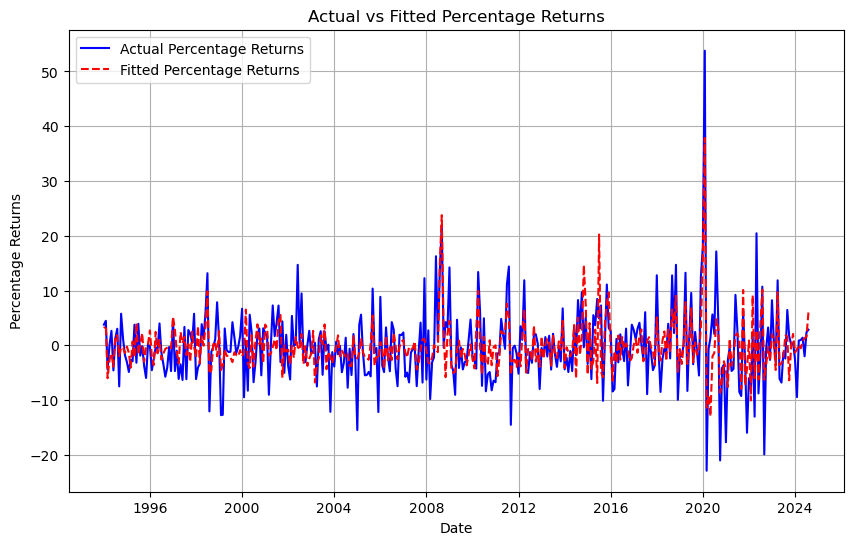

In [27]:
# - Compares percentage returns from the actual data and the model's predictions.
# - Useful for assessing the model's accuracy in capturing return dynamics.

# Align fitted values and actual values by matching indices
model_index = df.index[model_with_lags.model.data.row_labels]
y_actual_aligned = df["PctRetEnergy"].loc[model_index]
y_fitted = model_with_lags.fittedvalues

plt.figure(figsize=(10, 6))

# Plot actual vs fitted percentage returns
plt.plot(model_index, y_actual_aligned, label="Actual Percentage Returns", color="blue", linestyle="-")
plt.plot(model_index, y_fitted, label="Fitted Percentage Returns", color="red", linestyle="--")

# Plot formatting
plt.title("Actual vs Fitted Percentage Returns")
plt.xlabel("Date")
plt.ylabel("Percentage Returns")
plt.legend()
plt.grid(True)
plt.show()

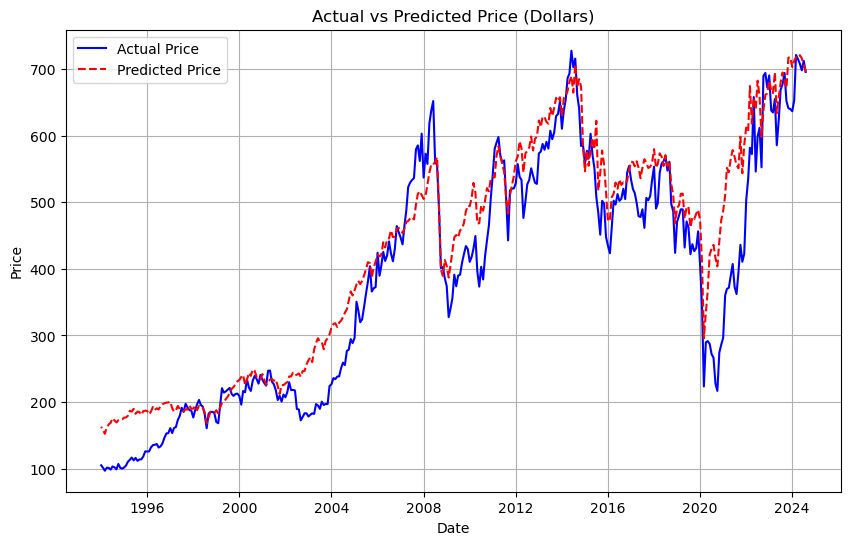

In [28]:
# - Converts model's percentage return predictions into raw price predictions.
# - The comparison highlights the model's ability to track price movements.

# Fitted percentage returns from the model
fitted_returns = model_with_lags.fittedvalues
common_index = df.index[model_with_lags.model.data.row_labels]

# Align actual price to the same index
df_aligned = df.loc[common_index]

# Reverse-calculate predicted prices from percentage returns
predicted_prices = [df_aligned["sp500_energy"].iloc[0]]  # Start with the first aligned price
for i in range(1, len(common_index)):
    r_t = fitted_returns.iloc[i]  # Fitted percentage return
    next_price = predicted_prices[-1] * (1 + r_t / 100.0)
    predicted_prices.append(next_price)

# Convert predicted prices to a Series
predicted_price_series = pd.Series(predicted_prices, index=common_index, name="PredictedPrice")

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(df_aligned.index, df_aligned["sp500_energy"], label="Actual Price", color="blue", linestyle="-")
plt.plot(predicted_price_series.index, predicted_price_series, label="Predicted Price", color="red", linestyle="--")

# Plot formatting
plt.title("Actual vs Predicted Price (Dollars)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Confidence and Prediction Intervals  

This plot illustrates the fitted percentage returns of the S&P 500 Energy Index alongside their actual values, accompanied by 95% confidence and prediction intervals.

Interpretation:
- The fitted values (red dashed line) closely track the actual percentage returns (blue dots) for most data points, demonstrating the model’s ability to capture general trends in the data. However, there are noticeable deviations during periods of extreme market fluctuations, such as the spike in 2020, where the actual values far exceed the fitted values.
- The 95% confidence interval (gray band) represents the uncertainty in the mean predictions, and it remains relatively narrow throughout the time series, indicating a high degree of precision in estimating the average return.
- The 95% prediction interval (yellow band) is wider, accounting for the variability in individual observations. While most actual values fall within this interval, some outliers, particularly the large deviations during extreme events, exceed the prediction range.

This chart confirms that the model performs well in capturing typical movements of the S&P 500 Energy Index returns but struggles to predict extreme events accurately. The confidence and prediction intervals offer a meaningful sense of uncertainty, highlighting areas where the model’s reliability is stronger (e.g., stable periods) versus weaker (e.g., high-volatility periods). Despite occasional mismatches, the fitted values generally align well with the actual returns, showcasing the model’s utility in predicting short-term returns under normal market conditions.

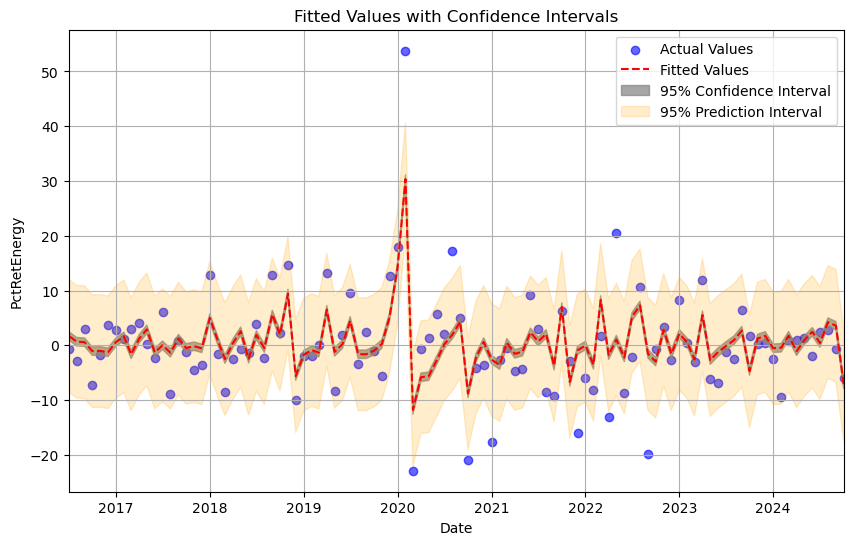

In [29]:
# Extract relevant columns
PctRetOil = df["PctRetOil"]
PctRetVix = df["PctRetVix"]
reer_exchange_diff = df["reer_exchange_diff"]
# Interaction term
interaction_term = PctRetOil * PctRetVix
# Regression coefficients
intercept = 0.7773
beta_oil = 0.2136
beta_vix = -0.1164
beta_reer_cum = -0.369
beta_interaction = -0.0053

# Calculate fitted values (y_hat)
y_fitted = (
    intercept
    + beta_oil * PctRetOil
    + beta_vix * PctRetVix
    + beta_reer_cum * reer_exchange_diff
    + beta_interaction * interaction_term
)

# Calculate confidence intervals.
prediction_se = model_with_lags.bse  # Standard errors of model coefficients
ci_upper = y_fitted + 1.96 * prediction_se.mean()
ci_lower = y_fitted - 1.96 * prediction_se.mean()
# Calculate prediction intervals.
# Extract residual variance from the model
residual_variance = model_with_lags.mse_resid  # Mean squared error of residuals
se_y_pred = np.sqrt(prediction_se.mean()**2 + residual_variance)
pi_lower = y_fitted - 1.96 * se_y_pred  # 95% prediction interval lower bound
pi_upper = y_fitted + 1.96 * se_y_pred  # 95% prediction interval upper bound

# ------------ Plotting ---------------------
plt.figure(figsize=(10, 6))
# Actual data (scatter)
plt.scatter(df.index, df["PctRetEnergy"], label="Actual Values", color="blue", alpha=0.6)
# Fitted values (line)
plt.plot(df.index, y_fitted, label="Fitted Values", color="red", linestyle="--")
# Confidence intervals (shaded area)
plt.fill_between(df.index, ci_lower, ci_upper, color="gray", alpha=0.7, label="95% Confidence Interval")
# Prediction intervals (shaded area)
plt.fill_between(df.index, pi_lower,pi_upper,color="orange",alpha=0.2,label="95% Prediction Interval")
# Limiting the data set
plt.xlim([df.index[-100], df.index[-1]])
# Customize the plot
plt.title("Fitted Values with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("PctRetEnergy")
plt.legend()
plt.grid(True)
plt.show()

## Robustness Check and External Validity 
To test the robustness and external validity of the chosen model, it was applied to the NYSE ARCA Oil Index (XOI), a price-weighted index tracking leading petroleum companies, including overlaps with the S&P 500 like Chevron and Exxon Mobil. Descriptive analysis revealed that the XOI is priced significantly higher than the S&P 500 Energy Index, with more pronounced fluctuations, particularly during the COVID-19 period when its percentage returns exhibited extreme volatility.

The regression results highlighted some key differences between the two indices. 
- While oil returns were a significant predictor in the S&P 500 model, they had no meaningful impact on the XOI.
- Sentiment categories, which were insignificant in the S&P 500 model, became relevant for the XOI. Negative sentiment showed a weak but consistent negative effect, and positive sentiment also had a small negative coefficient.
- Control variables like CPI differences and REER exchange differences were more influential in the XOI model, suggesting that inflation and currency dynamics play a stronger role in this index.
- Interestingly, the interaction term between oil returns and VIX, which was important for the S&P 500, was insignificant for the XOI, reflecting differing relationships with market volatility.

All coefficients in the XOI model had small beta values, which indicates that while the relationships are statistically significant, their practical impact on percentage returns is minimal. This may reflect structural differences in how XOI companies respond to these variables compared to the S&P 500. Additionally, the model for the XOI is more skewed than the original, possibly due to the heightened volatility and extreme fluctuations in the XOI returns, particularly during periods of market stress like COVID-19. These findings suggest that while the model provides some insights into the XOI, its ability to generalize across indices is limited by the structural and behavioral differences between them.

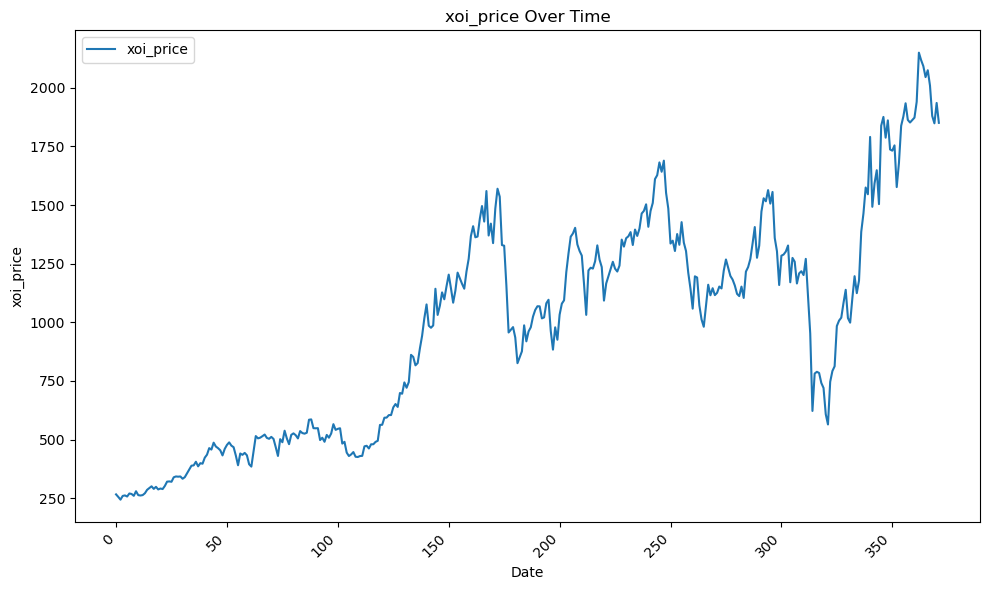

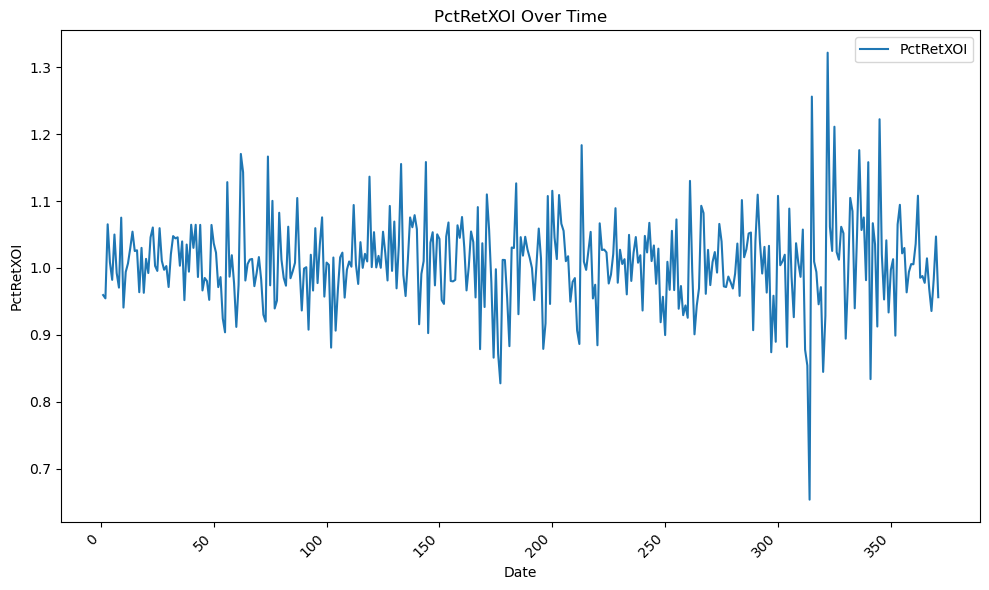

In [30]:
# open csv file
path_XOI= os.path.join('data', 'XOI.csv')
df_xoi = pd.read_csv()

df_xoi['date'] = pd.to_datetime(df_xoi['date']).dt.normalize()
df_xoi = df_xoi.drop(columns=['Unnamed: 0','open','high','low'])
df_xoi.rename(columns={"close": "xoi_price"}, inplace=True)
df_xoi.head()
# Feature engineer percentage return 
df_xoi["PctRetXOI"] = df_xoi["xoi_price"] / (df_xoi["xoi_price"].shift()) 
# Describtive Statistics 
df_xoi[["xoi_price","PctRetXOI"]].describe().T.round(2)
# Visualization
for var in df_xoi[["xoi_price","PctRetXOI"]]:
    if var != 'date':
        plt.figure(figsize=(10, 6))
        plt.plot(df_xoi[var], linestyle='-', label=var)
        plt.title(f'{var} Over Time')
        plt.xlabel('Date')
        plt.ylabel(var)
        plt.xticks(rotation=45, ha='right')  # Rotate date labels for readability
        plt.legend()
        plt.tight_layout()
        plt.show()
# xoi is more volitile and has a larger range 

In [31]:
df = pd.merge(df, df_xoi, on='date', how='left')

In [32]:
formula = """PctRetXOI ~ PctRetOil + PctRetVix + cpi_diff + interest_rates_diff +
             reer_exchange_diff + reer_exchange_diff_lag1 + reer_exchange_diff_lag2 +
             quantity_diff_full + C(sentiment_category_full, Treatment(reference="Neutral")) +
             PctRetOil:PctRetVix + PctRetOil:sentiment_category_full + 
             PctRetOil:quantity_diff_full + cpi_diff:quantity_diff_full + 
             PctRetVix:reer_exchange_diff"""

model_with_lags2 = smf.ols(formula=formula, data=df).fit(cov_type='HAC', cov_kwds={'maxlags': 2})
print(model_with_lags2.summary())
# checking VIF
X = df[['PctRetXOI', 'PctRetOil', 'PctRetVix', 'cpi_diff','interest_rates_diff', 'reer_exchange_diff','reer_exchange_diff_lag1','reer_exchange_diff_lag2',
'quantity_diff_full','sentiment_num']]
X_imputed = X.fillna(0)  # temporary null imputation 
vif_data = pd.DataFrame()
vif_data["Variable"] = X_imputed.columns
vif_data["VIF"] = [variance_inflation_factor(X_imputed.values, i) for i in range(X_imputed.shape[1])]
print(vif_data)

                            OLS Regression Results                            
Dep. Variable:              PctRetXOI   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     21.82
Date:                Mon, 30 Dec 2024   Prob (F-statistic):           5.96e-45
Time:                        00:32:44   Log-Likelihood:                 544.91
No. Observations:                 367   AIC:                            -1052.
Df Residuals:                     348   BIC:                            -977.6
Df Model:                          18                                         
Covariance Type:                  HAC                                         
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

In [33]:
# --- S&P500 vs XOI ---
# Combine the results of all models into a Stargazer table for comparison.
stargazer4 = Stargazer([model_with_lags, model_with_lags2])
stargazer4.title("Regression Results Comparison")
stargazer4.custom_columns(
    ["S&P500", "XOI"], 
    [1, 1]
)
stargazer4.show_model_numbers(True)
# Print the Stargazer table
stargazer4